## 1) Twitter
Данные вот отсюда: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [1]:
import requests
import pandas as pd
import io
import numpy
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import sklearn
import seaborn as sns
import random
import warnings; warnings.filterwarnings(action='once')
from datetime import datetime
import plotly.express as px
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import math
import catboost as cb
from regressors import stats

/opt/anaconda3/lib/python3.7/site-packages/nbformat/notebooknode.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [2]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

Посмотрим на наши данные по твитам. 

Основные столбцы в нём: 
* airline sentiment (общее настроение твита), 
* negativereason (причина негативности твита, если есть)
* airline (название авиакомпании)
* retweet_count (количество ретвитов)
* text (текст твита)
* tweer_created (время публикации) 
* tweet_location (место публикации твита)

In [3]:
tweets = pd.read_csv('Tweets.csv')
tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [4]:
len(tweets)

14640

Начнём предобработку данных. Вначале переведём время в прафильный формат

In [5]:
for i in range(len(tweets)):
    tweets.loc[i, 'tweet_created'] = tweets.loc[i, 'tweet_created'][:-6]
    tweets.loc[i, 'tweet_created'] = datetime.strptime(tweets.loc[i, 'tweet_created'], '%Y-%m-%d %H:%M:%S')
    
tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

         tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45            NaN  Pacific Time (US & Canada)

Построим гистограммы всех интересных параметров

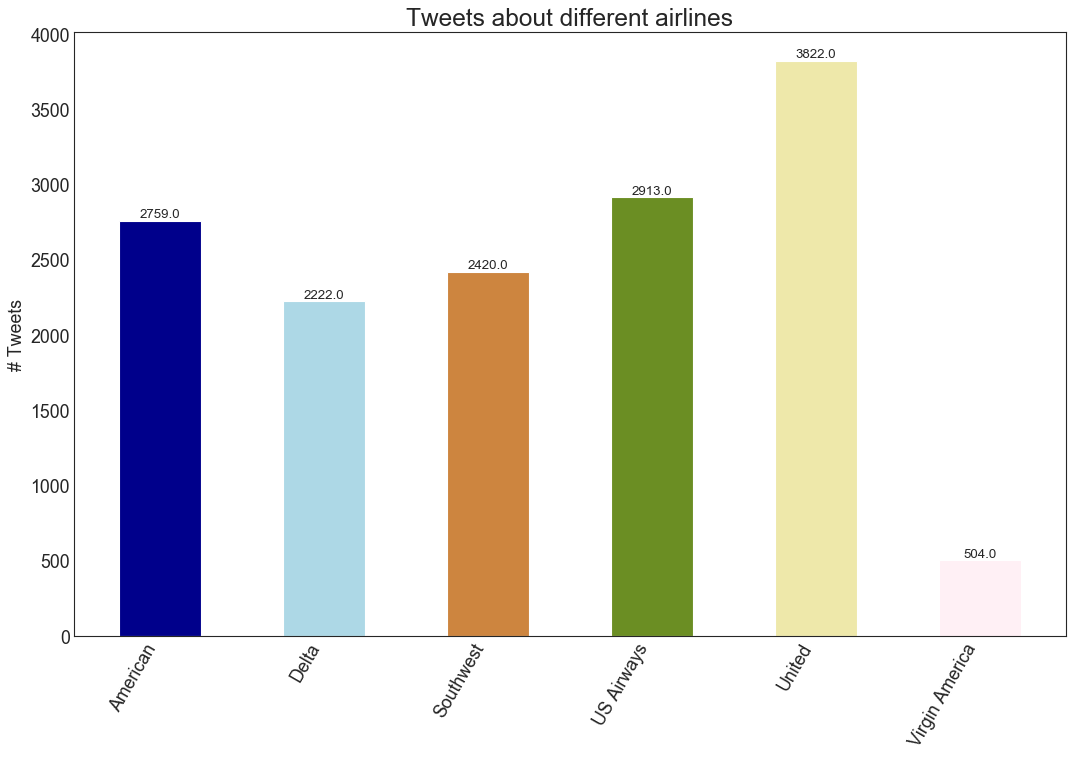

In [6]:
df = tweets.groupby('airline').size().reset_index(name='counts')
n = df['airline'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['airline'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df['airline'], rotation=60, horizontalalignment= 'right')
plt.title("Tweets about different airlines", fontsize=22)
plt.ylabel('# Tweets')
plt.show()

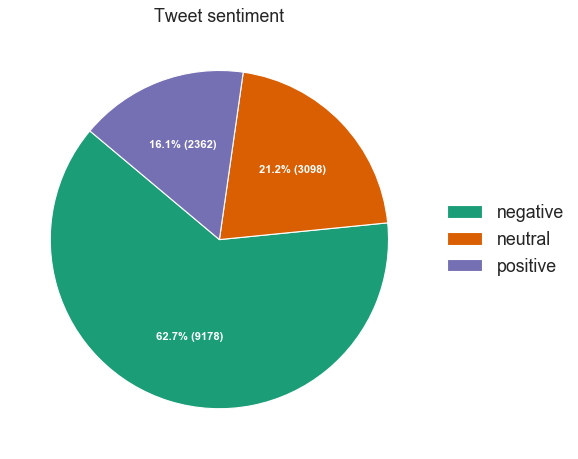

In [7]:
df = tweets.groupby('airline_sentiment').size().reset_index(name='counts')

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df['counts']
categories = df['airline_sentiment']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140)

ax.legend(wedges, categories, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Tweet sentiment")
plt.show()

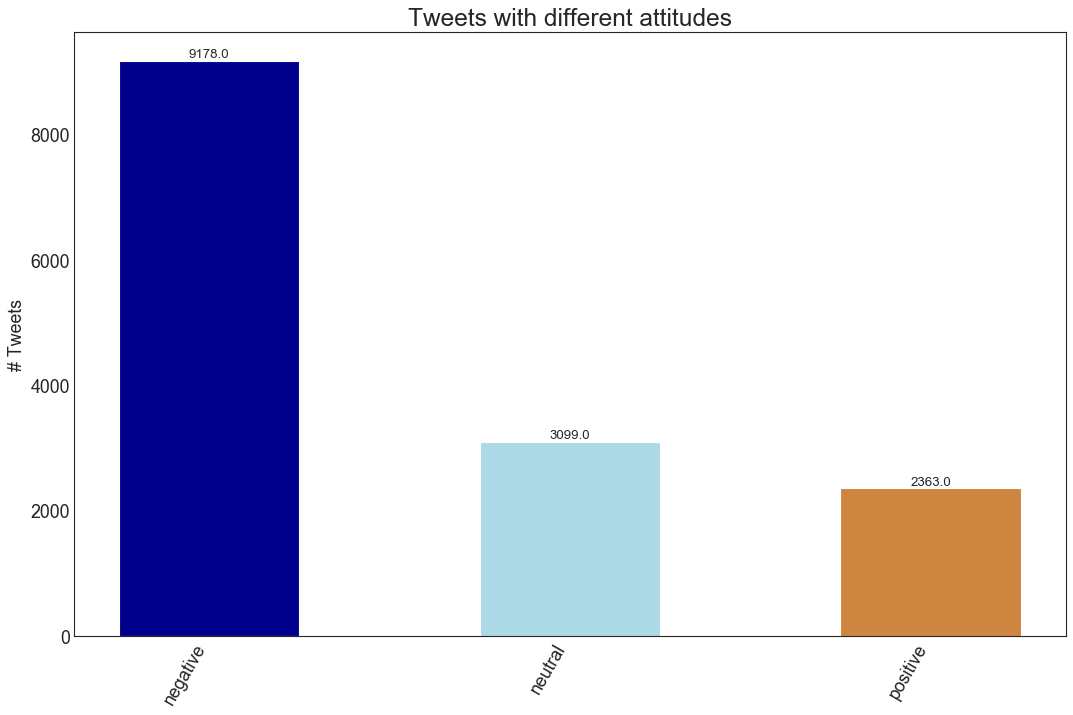

In [8]:
df = tweets.groupby('airline_sentiment').size().reset_index(name='counts')
n = df['airline_sentiment'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['airline_sentiment'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df['airline_sentiment'], rotation=60, horizontalalignment= 'right')
plt.title("Tweets with different attitudes", fontsize=22)
plt.ylabel('# Tweets')
plt.show()

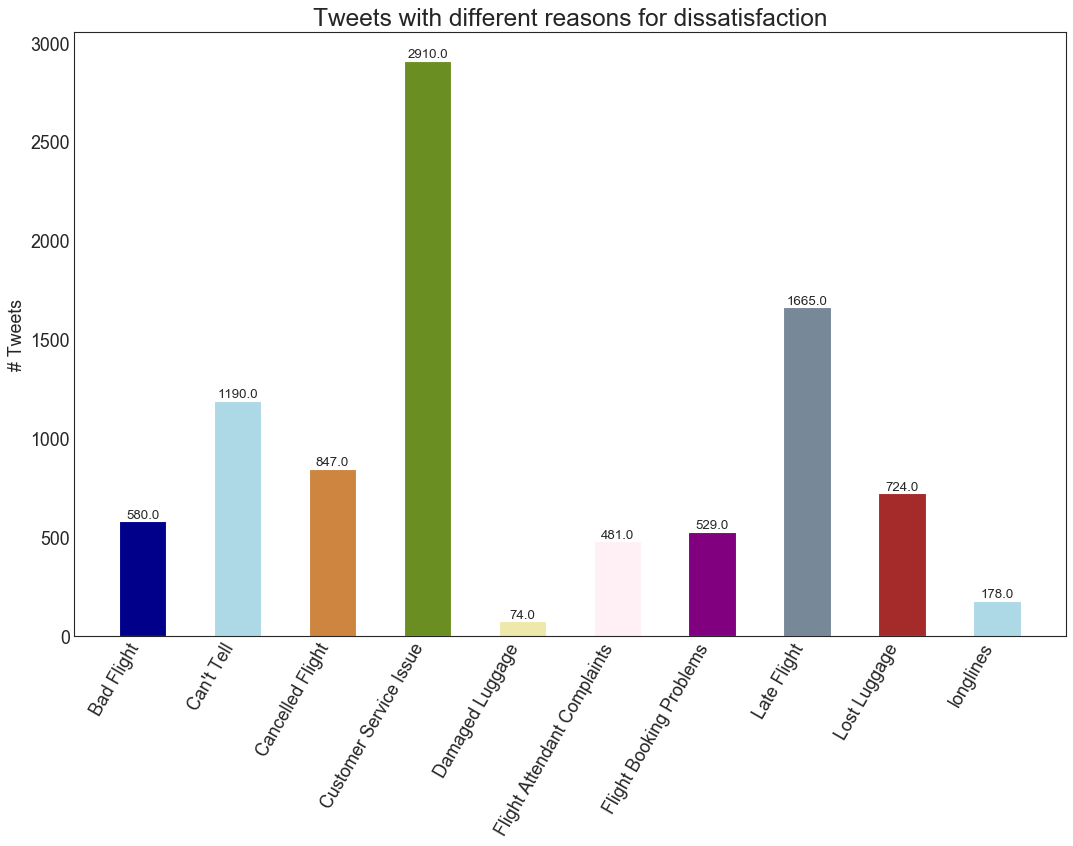

In [9]:
df = tweets.groupby('negativereason').size().reset_index(name='counts')
n = df['negativereason'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['negativereason'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df['negativereason'], rotation=60, horizontalalignment= 'right')
plt.title("Tweets with different reasons for dissatisfaction", fontsize=22)
plt.ylabel('# Tweets')
plt.show()

Посчитаем, сколько люди писали твитов каждый день и построим по этому графики (в виде гистограммы и time-series). По ним можно будет узнать, в какие дни недели люди пишут активнее всего. От этого будет зависеть работа поддержки и обновление данных при решении этой задачи в реальной жизни

In [10]:
days = []
for i in range(len(tweets)):
    days.append(tweets.iloc[i]['tweet_created'].day)
    
set(days)

{16, 17, 18, 19, 20, 21, 22, 23, 24}

<BarContainer object of 9 artists>

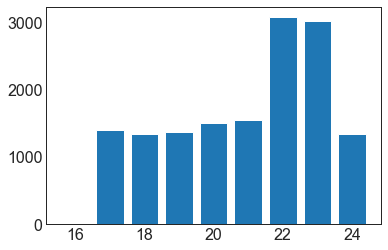

In [11]:
c = Counter(days)

plt.bar(c.keys(), c.values())

In [12]:
df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df = df.rename(columns={"index": "Day", 0: "Number of tweets"})
df

Day  Number of tweets
0   24              1344
1   23              3028
2   22              3079
3   21              1557
4   20              1500
5   19              1376
6   18              1344
7   17              1408
8   16                 4

In [13]:
fig = px.line(df, x='Day', y='Number of tweets')
fig.show()

22 и 23 число (на которые на графике приходится пик) - это были воскресенье и понедельник соответственно. Скорее всего люди активнее пишут в эти дни, потому что оставляют комментарии о своих полётах на выходных

Для тех же целей можно произвести аналогичный анализ по времени суток написания твитов

In [14]:
hours = []
for i in range(len(tweets)):
    hours.append(tweets.iloc[i]['tweet_created'].hour)
    
set(hours)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23}

<BarContainer object of 24 artists>

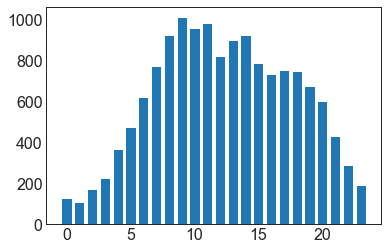

In [15]:
c = Counter(hours)

plt.bar(c.keys(), c.values())

In [16]:
df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df = df.set_index('index')
df.sort_index(inplace=True)
df = df.reset_index()
df = df.rename(columns={"index": "Hour", 0: "Number of tweets"})
df.head()

Hour  Number of tweets
0     0               131
1     1               111
2     2               174
3     3               225
4     4               368

In [17]:
fig = px.line(df, x="Hour", y="Number of tweets")
fig.show()

Как мы видим, пик приходится на первую половину дня: с 8 до 14 часов

Всю ту же информацию можно визуализировать выборочно для одной из авиакомпаний, на которой нам нужно будет заострить внимание

In [18]:
tweets_united = tweets[tweets['airline'] == "United"].copy()
tweets_united.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
504  570307876897628160          positive                        1.0000   
505  570307847281614848          positive                        1.0000   
506  570307109704900608          negative                        1.0000   
507  570307026263384064          negative                        1.0000   
508  570306733010264064          positive                        0.3441   

       negativereason  negativereason_confidence airline  \
504               NaN                        NaN  United   
505               NaN                        NaN  United   
506  Cancelled Flight                      0.703  United   
507       Late Flight                      1.000  United   
508               NaN                      0.000  United   

    airline_sentiment_gold            name negativereason_gold  retweet_count  \
504                    NaN      rdowning76                 NaN              0   
505                    NaN   CoreyAStewart                 NaN              0   
506                    NaN  CoralReefer420                 NaN              0   
507                    NaN      lsalazarll                 NaN              0   
508                    NaN          rombaa                 NaN              0   

                                                  text tweet_coord  \
504                                     @united thanks         NaN   
505  @united Thanks for taking care of that MR!! Ha...         NaN   
506  @united still no refund or word via DM. Please...         NaN   
507  @united Delayed due to lack of crew and now de...         NaN   
508  @united thanks -- we filled it out. How's our ...         NaN   

           tweet_created         tweet_location                user_timezone  
504  2015-02-24 11:42:48                    usa                          NaN  
505  2015-02-24 11:42:41           Richmond, VA   Eastern Time (US & Canada)  
506  2015-02-24 11:39:45  Bay Area, California                        Alaska  
507  2015-02-24 11:39:25                    NaN  Mountain Time (US & Canada)  
508  2015-02-24 11:38:15                    NaN                          NaN

In [19]:
days = []
for i in range(len(tweets_united)):
    days.append(tweets.iloc[i]['tweet_created'].day)
    
set(days)

{17, 18, 19, 20, 21, 22, 23, 24}

In [20]:
c = Counter(days)
df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df = df.rename(columns={"index": "Day", 0: "Number of tweets"})
df['Number of tweets'].mean()

477.75

Можно также внимательнее посмотреть на место создание твитов. Они написаны в разном формате, но можно попробовать вытащить твиты из Нью-Йорка, например, по разным его сокращениям

In [21]:
for i in tweets['tweet_location']:
    print(i)

nan
nan
Lets Play
nan
nan
nan
San Francisco CA
Los Angeles
San Diego
Los Angeles
1/1 loner squad
NYC
NYC
nan
San Francisco, CA
palo alto, ca
west covina
this place called NYC
Somewhere celebrating life. 
Boston | Waltham
nan
nan
Los Angeles
Boston, MA 
714
nan
nan
San Francisco, CA
San Mateo, CA & Las Vegas, NV
Brooklyn
nan
California, San Francisco
Washington DC
nan
Texas
Worldwide
Central Texas
Central Texas
i'm creating a monster 
San Francisco, CA
nan
Iowa City
Los Angeles
Georgia
nan
Los Angeles
Turks and caicos
Oakland via Midwest 
New York, NY
nan
Worldwide
Northern Virginia
Los Angeles / Atlanta
nan
nan
new york, new york
brooklyn, Ny
Bali, Republic of Indonesia
UK, USA. 
Gold Coast, Australia
Stockton, CA
New York, NY
nan
Twin Cities, Minn.
nan
USA
next city
SF ↔ NY
New York, NY
New York + Panama
San Francisco, CA
Los Angeles
London, England
Los Angeles
Floridian from Cincinnati 
Dallas, Texas
USA
Dallas, Texas
nan
nan
nan
Seattle, WA
Los Angeles
nan
nan
Lower Pacific Heights,

Denver, CO
Chorley, Lancashire
nan
Sheboygan
Boston
Dallas, Texas
nan
P.R.O.B. 
Roma
East Coast
nan
Park Slope
Lewis Center, OH
Richmond, VA
nan
nan
DOM-ination
nan
Wilmington, Delaware
Buffalo/Oakland/Savannah/Ire
nan
US
nan
Beijing
Cleveland, Ohio
North West of England
nan
San Francisco
nan
nan
San Francisco, CA
nan
Brownsville, Tx
nan
nan
Raleigh, NC
Indiana
New York/New Jersey
New York/New Jersey
Lexington, Ky
New York/New Jersey depends on
Los Angeles
nan
nan
nan
Portland, OR
Western Massachusetts, USA
London baby
nan
176 Thomas Johnson Drive, #204
Toronto
Portland, OR
nan
nan
nan
nan
nan
Bay Area, CA
San Francisco, Ca
nan
SD || CA   
Vancouver, CA
nan
nan
Vancouver, CA
Vancouver, CA
Vancouver, CA
nan
nan
New York/New Jersey depends on
nan
Bay Area, CA
Bay Area, CA
London
New Haven, CT
Los Angeles, CA
nan
Boston, MA
Boston, MA
nan
nan
St. Louis MO
nan
Los Angeles 
nan
Los Angeles 
nan
EP TX
Grand Rapids
nan
nan
Washington D.C. 
nan
nan
Buffalo, Ny
Canada
nan
Chicago
ÜT: 31.333857,

nan
nan
nan
nan
nan
nan
nan
nan
just living the dream 
nan
just living the dream 
Minnesota, USA
GORGEOUS UNIVERSE
The Garden State
Bethlehem, PA
England
Chicago
nan
nan
Raleigh, NC
nan
nan
nan
midwest and sometimes Spain
nan
Fresno, CA
One of the C-gates at EWR.
nan
Raleigh, NC
Raleigh, NC
just living the dream 
nan
Global
Madison, WI
Washington, DC
Grand Rapids, Michigan
Bethlehem, PA
nan
31.790466, -85.971558
nan
nan
The Garden State
nan
England
nan
nan
Seattle WA
Seattle WA
New York City
America
nan
SoCal
Seattle WA
Seattle WA
nan
One of the C-gates at EWR.
San Francisco
Rochester NY
nan
Houston, TX
nan
Chicago, IL
nan
new york, baby
Central Sq. Cambridge, MA
Forest Grove, OR
31.790466, -85.971558
nan
Forest Grove, OR
Vancouver, BC

nan
nan
San Diego 
nan
nan
Richmond, VA
Silicon Valley, CA
midwest and sometimes Spain
Washington, DC
ÜT: 39.768182,-86.167261
washington dc
Portland, Oregon
nan
Pittsburgh
Houston, TX
SoCal
nan
nan
nan
nan
nan
nan
Beautiful Stockton, CA
Washington, DC


North Tonawanda
St. Pete
Memphis
NYC
Memphis
Memphis
The Lone Star State
The Lone Star State
NYC
nan
North West of England
nan
Bozeman, Montana
nan
Usually in a plane
nan
nan
Denver, CO
North Hollywood, CA
nan
nan
nan
nan
nan
Plattsburgh, New York
fairfield county, connecticut
nan
Colorado
nan
NJ/NYC
nan
Northwestern NJ
nan
ÜT: 40.635407,-73.991869
Toronto
Northwestern NJ
Port Washington, NY 11050
Washington, DC
Southern New Jersey
nan
Houston
Massachusetts  
Houston, Texas
nan
nan
nan
nan
ottawa
All Over The World
nan
All Over The World
NYC, Toronto 
Halifax, Nova Scotia
nan
pittsburgh
nan
Deerfield
Indianapolis
nan
nan
Bhutan
Usually in a plane
Bhutan
Bhutan
nan
nan
Bhutan
Kanasa City
Bhutan
So Cal
Salt Lake City, Utah
Bhutan
Bhutan
Bhutan
New York, NY
nan
Bhutan
Nova Scotia
Toronto
West Palm Beach 
nan
North West of England
Island of Oahu, Hawaii
Los Gatos, CA 
Jerusalem-London-Antwerp
Tucson, AZ and Vancouver, BC
Bhutan
Virginia
Boston, MA
Wheatridge,Colo
Houston
ÜT: 40.976702,-72.

JerseyNY✈ATL
Lost In The Ether
New York, NY
NH
nan
Colorado
Louisville, KY
San Diego, Ca
Atlanta, GA
nan
Salt Lake City, UT
nan
KC
Murfreesboro, TN
New Jersey / Munich
Nashville, TN
nan
nan
KC
Abuja
The Universe
nan
Baton Rouge, LA
nan
nan
Oklahoma City, OK
Denver Co
Egg Harbor, WI
Nashville, TN
Washington DC, New York
nan
musician and music enthusiast
Columbus, Ohio
nan
Farmington, Utah
Dallas, TX
Ontario, Canada
Washington DC, New York
nan
Salt Lake City
Singapore
nan
nan
Rhode Island ,Mass,CT
nan
LA // DC // LA
Austin, TX
nan
Long Island, NY
Dallas, TX
Long Island, NY
Dallas, TX Memphis, TN, MS
LA // DC // LA
Oklahoma City
Salt Lake City
Los Angeles, California
nan
nan
nan
Albany, NY
Nebraska 
nan
Boston, MA
Boston, MA
nan
nan
CT
The Universe
Boston, MA
North Bethesda, MD
The Universe
nan
nan
nan
nan
nan
#PureMichigan 
Barrington, Rhode Island
nan
nan
43.012983,-78.724003
Columbus, Ohio
Washington, DC
Ohio
nan
Ohio
St Louis
South Carloina
Den10
nan
Omaha, NE 
Englewood, Florida
nan


Las Cruces, NM
nan
Boston, MA
nan
nan
Boston, MA
iPhone: 40.955353,-73.813942
NY,NY
Buffalo, New York
Vermont
iPhone: 40.955353,-73.813942
NY,NY
Boston
New York/New Jersey
nan
New York, NY
South Florida
New York, NY
New York, NY
New York, NY
central mass
central mass
nan
Buffalo
nan
nan
nan
nan
nan
Dubai 
boston ma
nan
KFDK
Austin
Boston, MA
Logan International Airport
Englewood, Florida
Fort Lauderdale, FL
New York
NYC 
Southern California
Portland, Maine
nan
ClayCo ATL
nan
nan
nan
nan
New York City
nan
NYC
NYC
Philadelphia/Cali
Boston, MA
805 CA
Boston, MA
805 CA
22nd Century
DC SF
Portland, Maine
Portland, Maine
Portland, Maine
Portland, Maine
nan
nan
nan
nan
nan
nan
nan
Portland, Maine
Portland, Maine
Portland, Maine
nan
Portland, Maine
nan
Logan International Airport
San Francisco, CA
Logan International Airport
Logan International Airport
New York
Los Angeles, CA
Logan International Airport
Logan International Airport
Logan International Airport
Somewhere being productive
nan
Lon

CT
New York, NY
❤
❤
plymouth 
New York, NY
USA
nan
Jetsetter ✈
New York City
ÜT: 40.96513,-73.872957
Jersey City, NJ 
Englewood, Florida
NYC | CT
New York City
NYC | CT
Wayne, NJ
New York City
nan
Wayne, NJ
NYC | CT
nan
Miramar, Florida
ÜT: 40.96513,-73.872957
nan
USA
NY
District of Columbia
San Diego, CA
NYC | CT
Boston, Massachusetts
NY
District of Columbia
NYC | CT
USA
NYC | CT
nan
Florida, USA
Long Island
North Carolina
Queens, NY
nan
nan
nan
Florida, USA
Long Island
Boston
Phoenix AZ
Boston, Ma.
North Carolina
USA
Austin, Texas, USA
nan
New York, NY
pnw
pnw
Clinton, CT 
Jersey City
Olean, NY
nan
USA
✈️✈️
iPhone: 60.495510,-151.064590
nan
austin, texas
nan
New York City
Boston, MA
Boston, MA
Boston, MA
nan
New York City
New York City
Portland, OR
USA
Portland, OR
Raleigh, NC
nan
Jamestown Virginia 
New York, NY
OH-LA-AZ-NY-AFG-IL-?
nan
New York, NY
Boston, MA
New York, NY
Jersey City, NJ
Jersey City, NJ
New York City
New York City
Melbourne, Australia
Jersey City, NJ
Charlotte, NC


Portland, Maine
this must be the place
nan
johnson city tn
johnson city tn
Washington, D.C.
nan
Burbank
nan
Grand Forks, ND
nan
NYC, NY
nan
nan
nan
nan
Sunshine State
nan
nan
johnson city tn
Dallas Fort Worth
Sunshine State
nan
nan
nan
L.A.
nan
nan
nan
nan
Berwyn, PA
Washington, DC via Boston
nan
Washington, DC
nan
nan
Washington, DC
Los Angeles, Ca
nan
nan
nan
Washington, DC
nan
south beach/ LA / NC
PHL | SFO | $x
Charlotte, NC
Washington DC
nan
south beach/ LA / NC
Indianapolis & environs
New York, New York
nan
babynole'18
nan
42.635976,-71.164046
nan
Washington D.C.
nan
nan
nan
Indianapolis & environs
Pittsburgh, PA
nan
Fairfield, Connecticut
Boston,MA
New York, New York
babynole'18
south beach/ LA / NC
nan
42.635976,-71.164046
nan
Jamaica
Boston,MA
Cincinnati
West Palm
West Palm
Delaware
Charlotte, NC
QueenCity, USA 
nan
nan
42.635976,-71.164046
nan
Jamaica
Jamaica
nan
nan
nan
nan
Washington, DC, USA
Delaware
Dixie State College
QueenCity, USA 
New York, New York
QueenCity, USA 
42

New York, NY
nan
nan
nan
nan
nan
nan
Kansas City, Missouri
Chicago, IL
nan
Frisco, Texas
Michigan, US
Washington, D.C.
Tampa, Florida
Oakland, CA
Tampa, Florida
Somewhere on Tyneside
McKinney TX
McKinney TX
new york city
new york city
Ft. Lauderdale
new york city
new york city
new york city
nan
'Straya'
nan
new york city
ÜT: -37.82304,144.961311
nan
North Hollywood
St. Louis, Missouri USA
nan
Chicago!
nan
I am from Internet!
Orlando, FL 
Lake County, Illinois
nan
nan
Lake County, Illinois
Boston
nan
Lake County, Illinois
Lee's Summit
New York, New York
Springfield, MO
NYC - Miami - Chicago
Brooklyn to Across the Globe
Cambridge, MA, USA
OREGON
Dallas, TX, USA
nan
New York, NY
nan
Preferably on a plane
birmingham, usa
Los Angeles, CA
 NYC
Manchester
McKinney TX
McKinney TX
I'm everywhere.
McKinney TX
nan
Manchester
Manchester
nan
Gold Coast, Australia
nan
Cambridge, MA, USA
Cambridge, MA, USA
Orlando, FL 
San Francisco
San Francisco
Cuenca, Azuay, Ecuador
nan
South
Gilbert, AZ
Michigan,

In [22]:
tweets['NY'] = 0

In [23]:
def NY(row):
    if (row['tweet_location'] != row['tweet_location']): 
        return 0
    if (row['tweet_location'].find("NY") != -1) or (row['tweet_location'].find("New York") != -1):
        return 1
    else:
        return 0
    
tweets['NY'] = tweets.apply(NY, axis=1)

In [24]:
tweets_ny = tweets[tweets['NY'] == 1].copy()

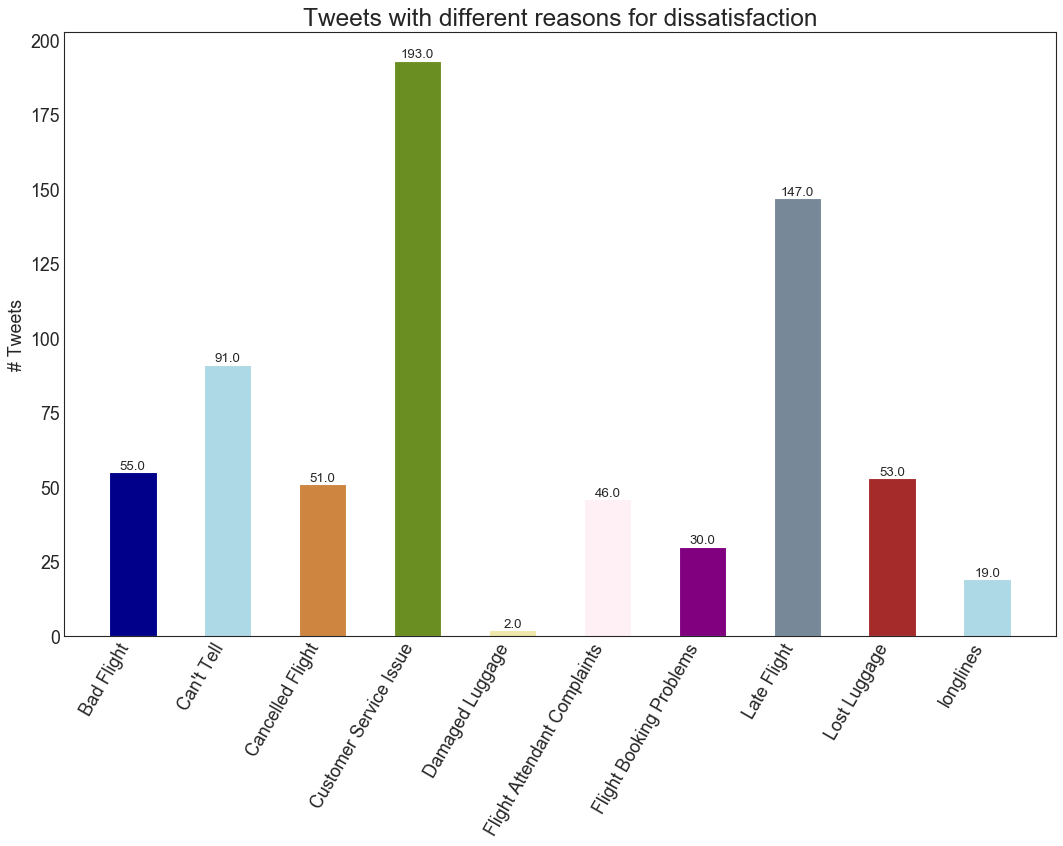

In [25]:
df = tweets_ny.groupby('negativereason').size().reset_index(name='counts')
n = df['negativereason'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['negativereason'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df['negativereason'], rotation=60, horizontalalignment= 'right')
plt.title("Tweets with different reasons for dissatisfaction", fontsize=22)
plt.ylabel('# Tweets')
plt.show()

В целом датафрейм не самый информативный. Компании в нём только американские, а период времени - вторая половина февраля 2015. Он подходит скорее как пример работы с такими данными и для того, чтобы показать потенциал такого исследования для авиакомпаний. Проведём более подробное исследование на следующих наборах данных.

## 2) Skytrax
Данные отсюда: https://www.kaggle.com/efehandanisman/skytrax-airline-reviews

Посмотрим на наши данные по отзывам.

Основные столбцы в нём: 
* airline (название авиакомпании)
* overall (общая оценка)
* review_date (дата публикации)
* customer_review (текст отзыва)
* traveller_type (тип поездки)
* cabin (класс)
* route (откуда и куда был полёт)
* seat_comfort, cabin_service, food_bev, entertainment, ground_service, value_for_money (оценки полёта по 6 параметрам по пятибальной шкале)
* recommended (рекомендует ли автор авиакомпанию)

In [26]:
skytrax = pd.read_excel('capstone_airline_reviews3.xlsx')
skytrax.head()

/opt/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.



airline  overall               author   review_date  \
0               NaN      NaN                  NaN           NaN   
1  Turkish Airlines      7.0  Christopher Hackley  8th May 2019   
2               NaN      NaN                  NaN           NaN   
3  Turkish Airlines      2.0        Adriana Pisoi  7th May 2019   
4               NaN      NaN                  NaN           NaN   

                                     customer_review aircraft  traveller_type  \
0                                                NaN      NaN             NaN   
1  âœ… Trip Verified | London to Izmir via Istanb...      NaN        Business   
2                                                NaN      NaN             NaN   
3  âœ… Trip Verified | Istanbul to Bucharest. We ...      NaN  Family Leisure   
4                                                NaN      NaN             NaN   

           cabin                         route           date_flown  \
0            NaN                           NaN                  NaN   
1  Economy Class  London to Izmir via Istanbul  2019-05-01 00:00:00   
2            NaN                           NaN                  NaN   
3  Economy Class         Istanbul to Bucharest  2019-05-01 00:00:00   
4            NaN                           NaN                  NaN   

   seat_comfort  cabin_service  food_bev  entertainment  ground_service  \
0           NaN            NaN       NaN            NaN             NaN   
1           4.0            5.0       4.0            4.0             2.0   
2           NaN            NaN       NaN            NaN             NaN   
3           4.0            1.0       1.0            1.0             1.0   
4           NaN            NaN       NaN            NaN             NaN   

   value_for_money recommended  
0              NaN         NaN  
1              4.0         yes  
2              NaN         NaN  
3              1.0          no  
4              NaN         NaN

Удалим совсем пустые строки, они тут зачем-то через одну в изначальных данных

In [27]:
skytrax.dropna(subset=['review_date'], inplace=True)
skytrax.head()

airline  overall               author   review_date  \
1  Turkish Airlines      7.0  Christopher Hackley  8th May 2019   
3  Turkish Airlines      2.0        Adriana Pisoi  7th May 2019   
5  Turkish Airlines      3.0            M Galerko  7th May 2019   
7  Turkish Airlines     10.0          Zeshan Shah  6th May 2019   
9  Turkish Airlines      1.0           Pooja Jain  6th May 2019   

                                     customer_review aircraft  traveller_type  \
1  âœ… Trip Verified | London to Izmir via Istanb...      NaN        Business   
3  âœ… Trip Verified | Istanbul to Bucharest. We ...      NaN  Family Leisure   
5  âœ… Trip Verified | Rome to Prishtina via Ista...      NaN        Business   
7  âœ… Trip Verified | Flew on Turkish Airlines I...     A330    Solo Leisure   
9  âœ… Trip Verified | Mumbai to Dublin via Istan...      NaN    Solo Leisure   

           cabin                           route           date_flown  \
1  Economy Class    London to Izmir via Istanbul  2019-05-01 00:00:00   
3  Economy Class           Istanbul to Bucharest  2019-05-01 00:00:00   
5  Economy Class  Rome to Prishtina via Istanbul  2019-05-01 00:00:00   
7  Economy Class    Washington Dulles to Karachi           April 2019   
9  Economy Class   Mumbai to Dublin via Istanbul  2019-05-01 00:00:00   

   seat_comfort  cabin_service  food_bev  entertainment  ground_service  \
1           4.0            5.0       4.0            4.0             2.0   
3           4.0            1.0       1.0            1.0             1.0   
5           1.0            4.0       1.0            3.0             1.0   
7           4.0            5.0       5.0            5.0             5.0   
9           1.0            1.0       1.0            1.0             1.0   

   value_for_money recommended  
1              4.0         yes  
3              1.0          no  
5              2.0          no  
7              5.0         yes  
9              1.0          no

Первое, что меня заинтересовало - это авиакомпании. Их тут много, попробуем их как-то обработать. Для начала посчитаем количество упоминаний каждой из них и процент от общего количества

In [28]:
skytrax_airlines = skytrax.groupby('airline').size().reset_index(name='counts')
print(len(skytrax_airlines))
skytrax_airlines.head()

81


airline  counts
0     ANA All Nippon Airways     473
1              Adria Airways      85
2            Aegean Airlines     531
3                 Aer Lingus     715
4  Aeroflot Russian Airlines     503

In [29]:
def airline(row):
    return row['counts'] / len(skytrax) * 100
    
skytrax_airlines['%'] = skytrax_airlines.apply(airline, axis=1)
skytrax_airlines.sort_values('counts', inplace=True, ascending=False)
skytrax_airlines = skytrax_airlines.reset_index()

skytrax_airlines.head()

index                 airline  counts         %
0     63         Spirit Airlines    2934  4.449027
1     17       American Airlines    2867  4.347431
2     73         United Airlines    2829  4.289808
3     22         British Airways    2811  4.262514
4     24  Cathay Pacific Airways    2402  3.642319

In [30]:
del skytrax_airlines['index']
skytrax_airlines.head()

airline  counts         %
0         Spirit Airlines    2934  4.449027
1       American Airlines    2867  4.347431
2         United Airlines    2829  4.289808
3         British Airways    2811  4.262514
4  Cathay Pacific Airways    2402  3.642319

Выделим 15 самых популярных, а остальные объединим вместе и отобразим это на круговой диаграмме

In [31]:
line = list(skytrax_airlines[15:].sum())
skytrax_airlines = skytrax_airlines[:15].copy()
skytrax_airlines.loc[15] = ["Other", line[1], line[2]]
skytrax_airlines

airline  counts          %
0           Spirit Airlines    2934   4.449027
1         American Airlines    2867   4.347431
2           United Airlines    2829   4.289808
3           British Airways    2811   4.262514
4    Cathay Pacific Airways    2402   3.642319
5          Air Canada rouge    2192   3.323881
6                  Emirates    1786   2.708235
7   China Southern Airlines    1722   2.611188
8         Frontier Airlines    1624   2.462584
9                   Ryanair    1566   2.374634
10          Delta Air Lines    1547   2.345823
11         Turkish Airlines    1491   2.260906
12            Qatar Airways    1445   2.191154
13                Lufthansa    1421   2.154761
14                Air India    1382   2.095622
15                    Other   35928  54.480113

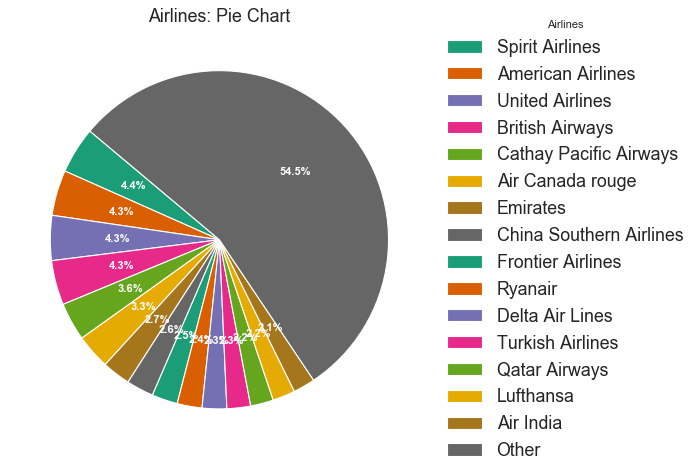

In [32]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = skytrax_airlines['counts']
categories = skytrax_airlines['airline']
explode = [0] * len(skytrax_airlines)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)

ax.legend(wedges, categories, title="Airlines", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Airlines: Pie Chart")
plt.show()

Дальше я прорисовал гистограммы по всем значимым столбцам, по ним можно отследить основные тренды в данных и распределение этих параметров

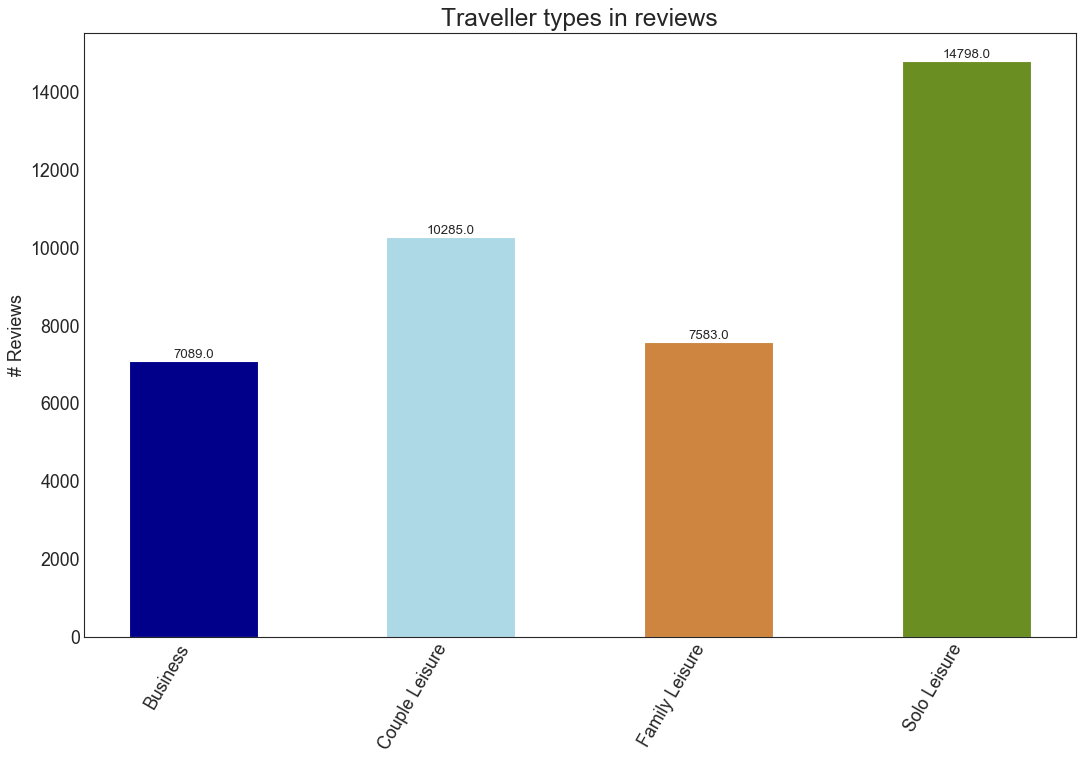

In [33]:
df = skytrax.groupby('traveller_type').size().reset_index(name='counts')
n = df['traveller_type'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['traveller_type'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df['traveller_type'], rotation=60, horizontalalignment= 'right')
plt.title("Traveller types in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

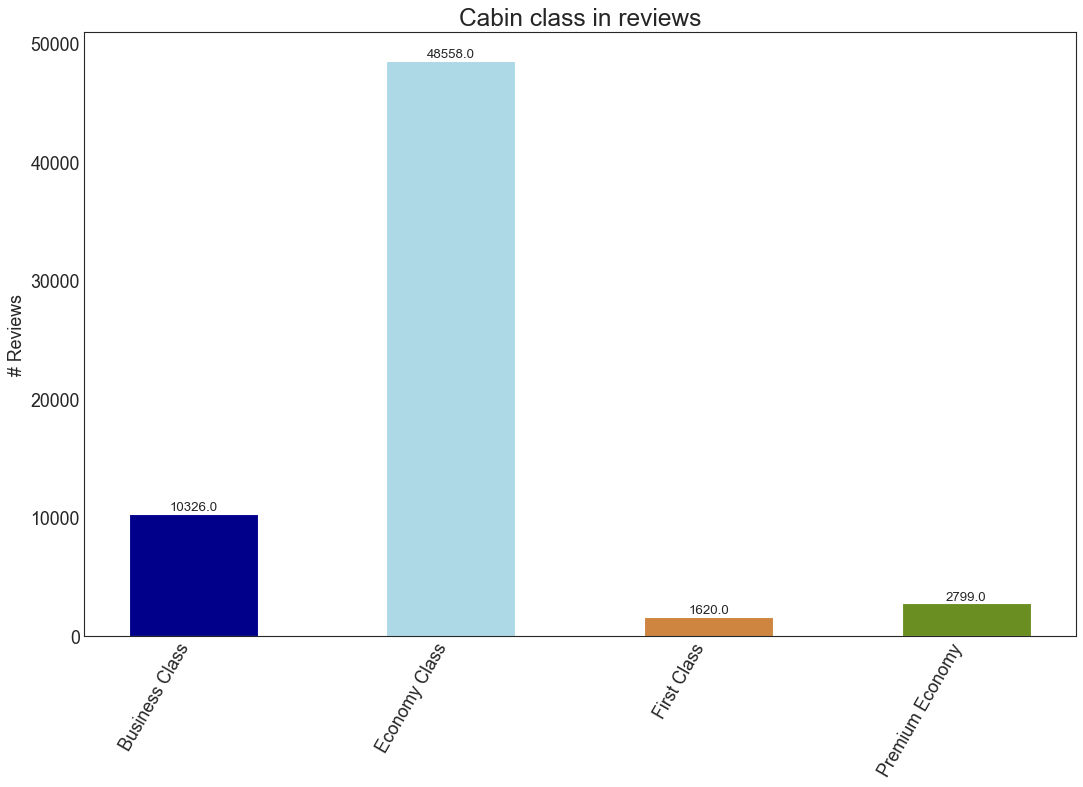

In [34]:
df = skytrax.groupby('cabin').size().reset_index(name='counts')
n = df['cabin'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['cabin'], df['counts'], color=c, width=.5)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Decoration
plt.gca().set_xticklabels(df['cabin'], rotation=60, horizontalalignment= 'right')
plt.title("Cabin class in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

Для параметров, отражающих оценки, здесь и далее я использовал один цвет столбцов на диаграмме (серый), чтобы они смотрелись как одно целое, а не как разные категории (как на других диаграммах)

64017.0
27.153724791852163 %
9.353765406064014 %
6.312385772529172 %
4.067669525282347 %
4.978365121764531 %
4.116094162488089 %
7.169970476592155 %
11.261071277941797 %
12.262367808550852 %
13.324585656934875 %


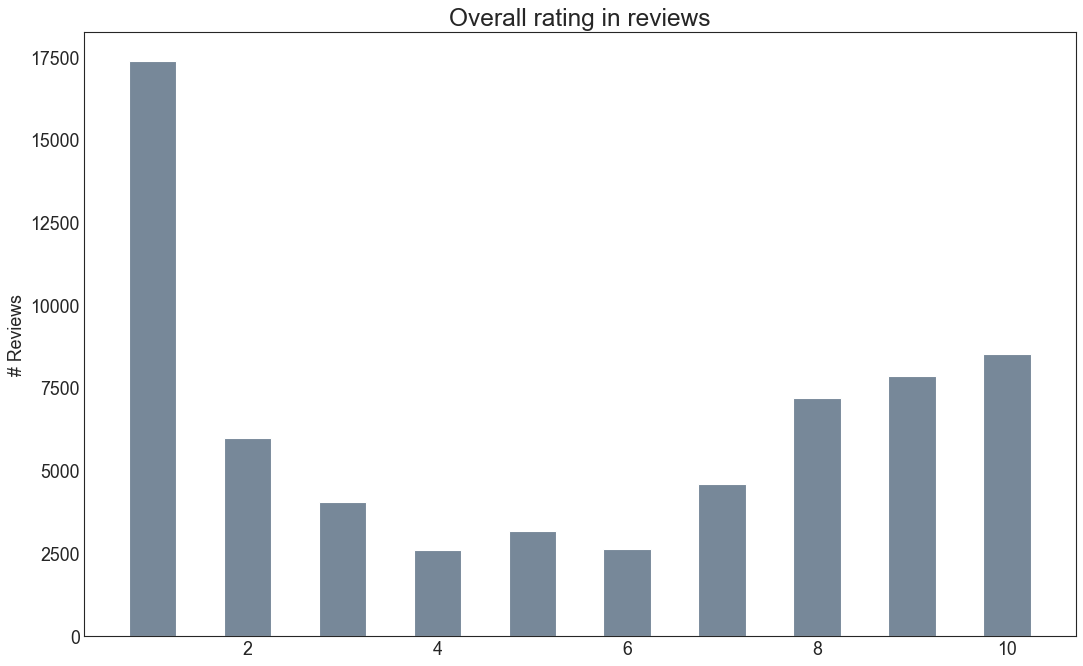

In [35]:
df = skytrax.groupby('overall').size().reset_index(name='counts')
c = 'lightslategray'

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['overall'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
print(summ)
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

plt.gca()
plt.title("Overall rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

In [36]:
len(skytrax)

65947

25.085282048746727 %
13.549545986387832 %
20.004614294424943 %
23.785039798289414 %
17.575517872151085 %


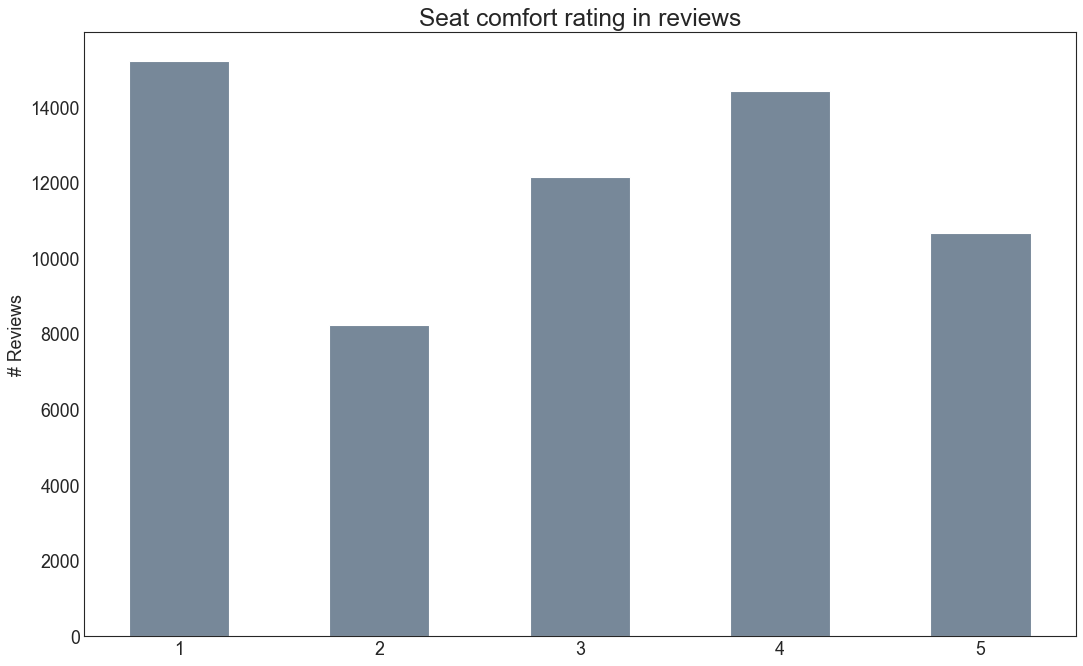

In [37]:
df = skytrax.groupby('seat_comfort').size().reset_index(name='counts')

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['seat_comfort'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

plt.gca()
plt.title("Seat comfort rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

60715.0
24.145598287078975 %
12.04644651239397 %
14.637239561887508 %
18.822366795684754 %
30.348348842954785 %


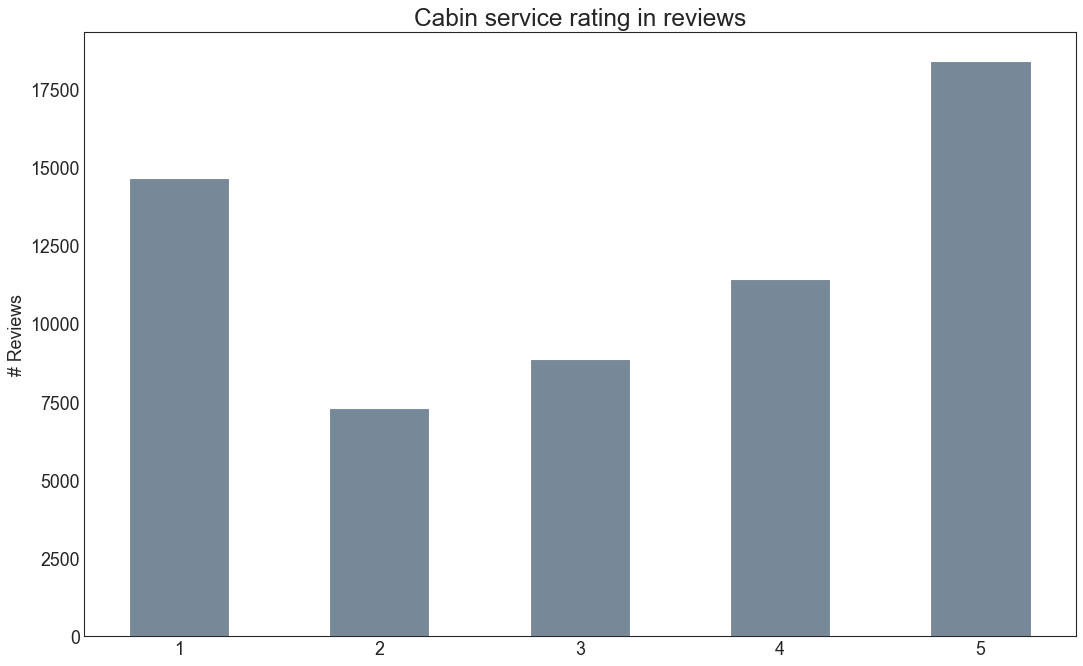

In [38]:
df = skytrax.groupby('cabin_service').size().reset_index(name='counts')

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['cabin_service'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
print(summ)
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

plt.gca()
plt.title("Cabin service rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

27.448296836982966 %
13.543567518248176 %
18.67396593673966 %
21.41119221411192 %
18.922977493917276 %


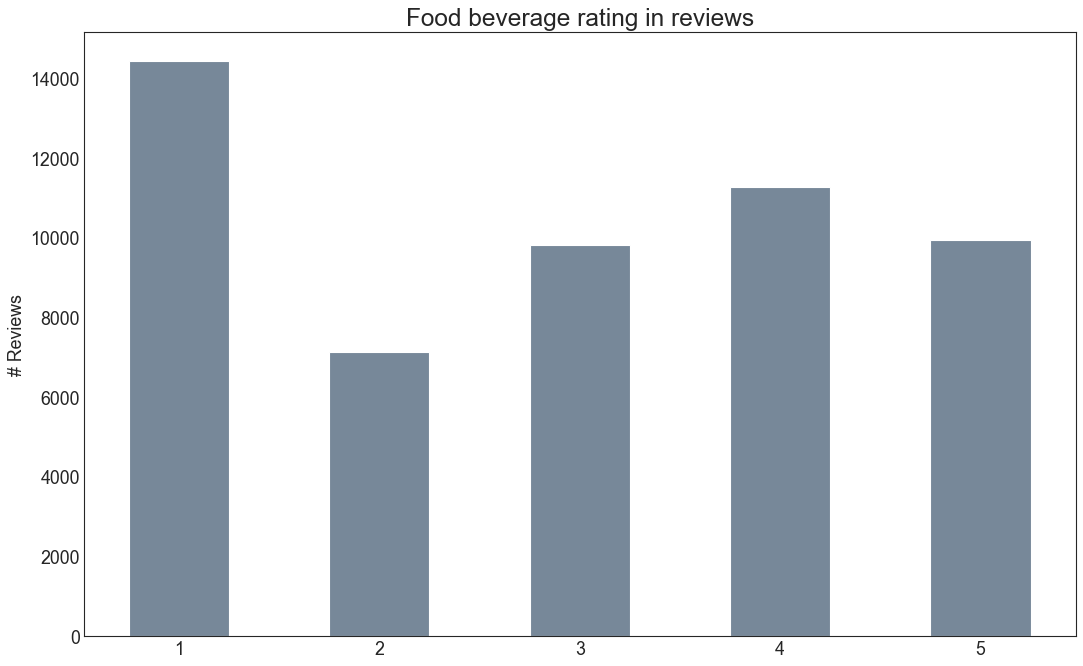

In [39]:
df = skytrax.groupby('food_bev').size().reset_index(name='counts')

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['food_bev'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

plt.gca()
plt.title("Food beverage rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

30.39395379358722 %
11.504084357251148 %
18.140882040142102 %
21.292964949200098 %
18.66811485981943 %


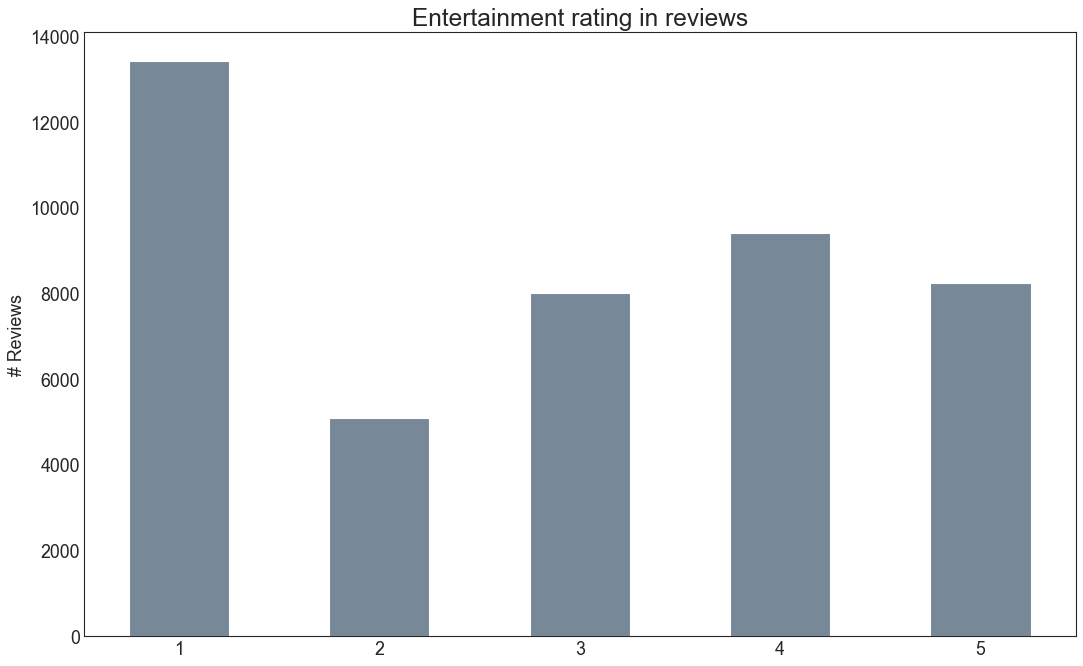

In [40]:
df = skytrax.groupby('entertainment').size().reset_index(name='counts')

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['entertainment'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

plt.gca()
plt.title("Entertainment rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

39358.0
39.99186950556431 %
9.390721073225265 %
12.630214949946645 %
17.317953148025815 %
20.66924132323797 %


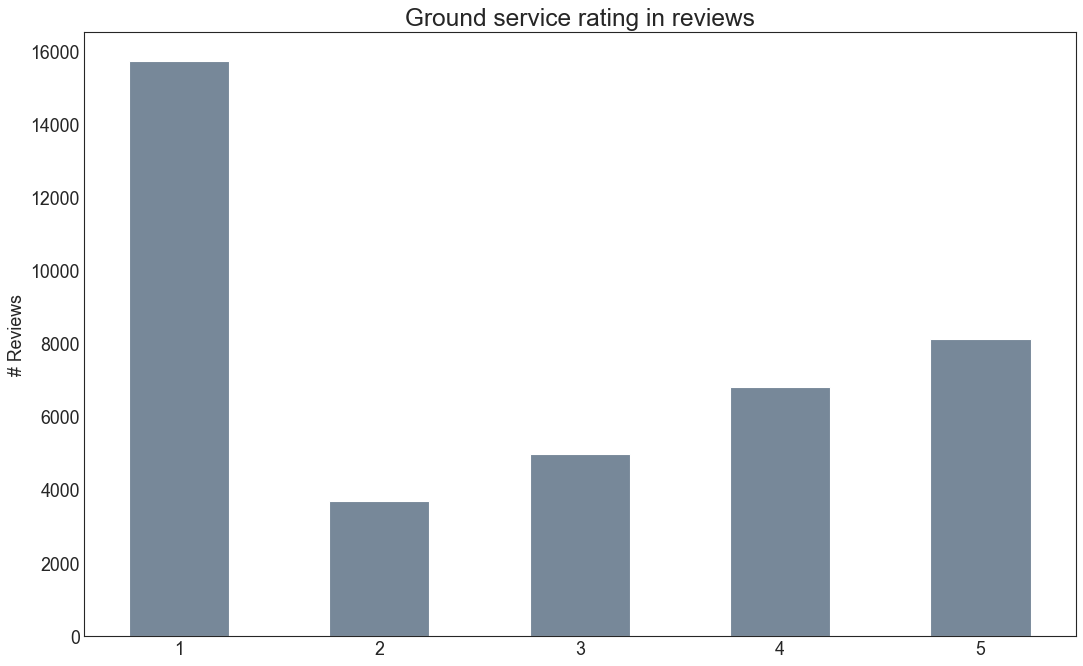

In [41]:
df = skytrax.groupby('ground_service').size().reset_index(name='counts')

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['ground_service'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
print(summ)
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

# Decoration
plt.gca()
plt.title("Ground service rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

31.04650254005471 %
11.781164517389605 %
12.925361469323954 %
20.223524814380617 %
24.023446658851114 %


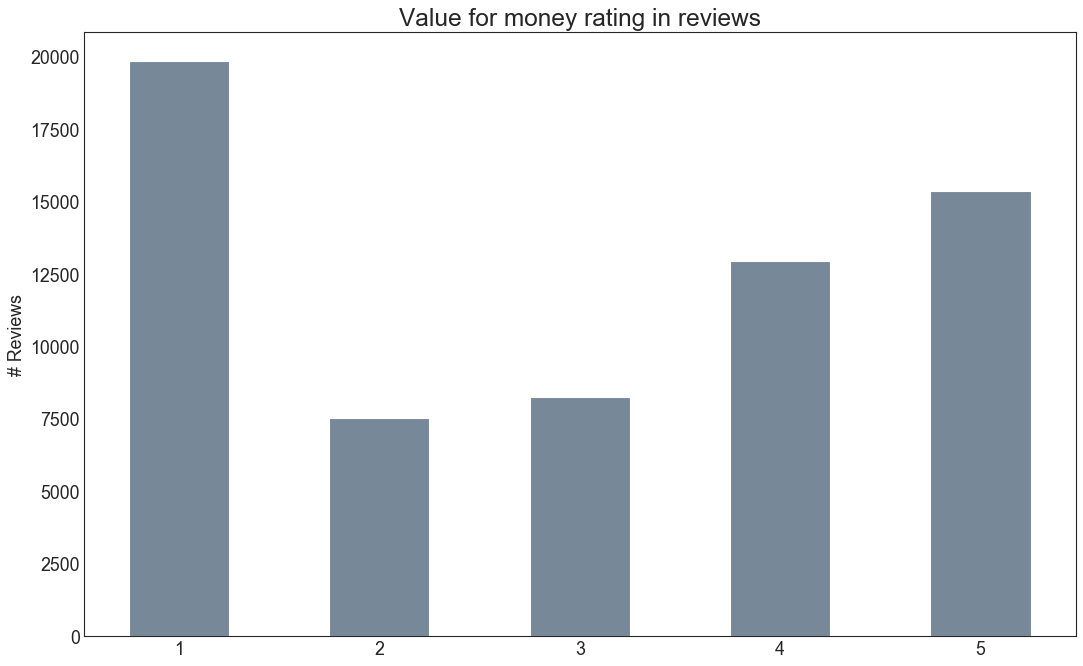

In [42]:
df = skytrax.groupby('value_for_money').size().reset_index(name='counts')

plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['value_for_money'], df['counts'], color=c, width=.5)

summ = 0
for i, val in enumerate(df['counts'].values):
    summ+= float(val)    
for i, val in enumerate(df['counts'].values):
    print(float(val) / summ * 100, '%')

plt.gca()
plt.title("Value for money rating in reviews", fontsize=22)
plt.ylabel('# Reviews')
plt.show()

Почти во всех оценках превалируют единицы, как и в общей оценке. Это говорит о том, что люди чаще всего пишут оценки именно чтобы высказать что-то негативное. По этой причине их стоит анализировать в первую очередь для нахождения "слабых мест" авиакомпании

Рекомендации нагляднее изобразить в виде круговой диаграммы, а не в виде гистограммы

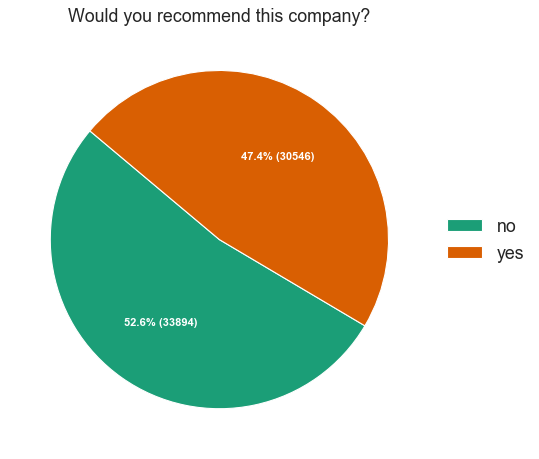

In [43]:
df = skytrax.groupby('recommended').size().reset_index(name='counts')

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df['counts']
categories = df['recommended']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140)

ax.legend(wedges, categories, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Would you recommend this company?")
plt.show()

Перейдём к созданию модели. 

Начнём с предобработки данных. Вначале уберём ненужные столбцы

In [44]:
df = skytrax.copy().reset_index(drop=True)
df.head()

airline  overall               author   review_date  \
0  Turkish Airlines      7.0  Christopher Hackley  8th May 2019   
1  Turkish Airlines      2.0        Adriana Pisoi  7th May 2019   
2  Turkish Airlines      3.0            M Galerko  7th May 2019   
3  Turkish Airlines     10.0          Zeshan Shah  6th May 2019   
4  Turkish Airlines      1.0           Pooja Jain  6th May 2019   

                                     customer_review aircraft  traveller_type  \
0  âœ… Trip Verified | London to Izmir via Istanb...      NaN        Business   
1  âœ… Trip Verified | Istanbul to Bucharest. We ...      NaN  Family Leisure   
2  âœ… Trip Verified | Rome to Prishtina via Ista...      NaN        Business   
3  âœ… Trip Verified | Flew on Turkish Airlines I...     A330    Solo Leisure   
4  âœ… Trip Verified | Mumbai to Dublin via Istan...      NaN    Solo Leisure   

           cabin                           route           date_flown  \
0  Economy Class    London to Izmir via Istanbul  2019-05-01 00:00:00   
1  Economy Class           Istanbul to Bucharest  2019-05-01 00:00:00   
2  Economy Class  Rome to Prishtina via Istanbul  2019-05-01 00:00:00   
3  Economy Class    Washington Dulles to Karachi           April 2019   
4  Economy Class   Mumbai to Dublin via Istanbul  2019-05-01 00:00:00   

   seat_comfort  cabin_service  food_bev  entertainment  ground_service  \
0           4.0            5.0       4.0            4.0             2.0   
1           4.0            1.0       1.0            1.0             1.0   
2           1.0            4.0       1.0            3.0             1.0   
3           4.0            5.0       5.0            5.0             5.0   
4           1.0            1.0       1.0            1.0             1.0   

   value_for_money recommended  
0              4.0         yes  
1              1.0          no  
2              2.0          no  
3              5.0         yes  
4              1.0          no

In [45]:
del df['airline']
del df['author']
del df['review_date']
del df['customer_review']
del df['route']
del df['date_flown']
df.head()

overall aircraft  traveller_type          cabin  seat_comfort  \
0      7.0      NaN        Business  Economy Class           4.0   
1      2.0      NaN  Family Leisure  Economy Class           4.0   
2      3.0      NaN        Business  Economy Class           1.0   
3     10.0     A330    Solo Leisure  Economy Class           4.0   
4      1.0      NaN    Solo Leisure  Economy Class           1.0   

   cabin_service  food_bev  entertainment  ground_service  value_for_money  \
0            5.0       4.0            4.0             2.0              4.0   
1            1.0       1.0            1.0             1.0              1.0   
2            4.0       1.0            3.0             1.0              2.0   
3            5.0       5.0            5.0             5.0              5.0   
4            1.0       1.0            1.0             1.0              1.0   

  recommended  
0         yes  
1          no  
2          no  
3         yes  
4          no

Преобразуем целевую переменную в правильный формат

In [46]:
def recommended(row):
    if (row['recommended'] == "yes"):
        return 1
    else:
        return 0
    
df['recommended'] = df.apply(recommended, axis=1)

df.head()

overall aircraft  traveller_type          cabin  seat_comfort  \
0      7.0      NaN        Business  Economy Class           4.0   
1      2.0      NaN  Family Leisure  Economy Class           4.0   
2      3.0      NaN        Business  Economy Class           1.0   
3     10.0     A330    Solo Leisure  Economy Class           4.0   
4      1.0      NaN    Solo Leisure  Economy Class           1.0   

   cabin_service  food_bev  entertainment  ground_service  value_for_money  \
0            5.0       4.0            4.0             2.0              4.0   
1            1.0       1.0            1.0             1.0              1.0   
2            4.0       1.0            3.0             1.0              2.0   
3            5.0       5.0            5.0             5.0              5.0   
4            1.0       1.0            1.0             1.0              1.0   

   recommended  
0            1  
1            0  
2            0  
3            1  
4            0

Затем построим матрицу корреляций признаков

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.



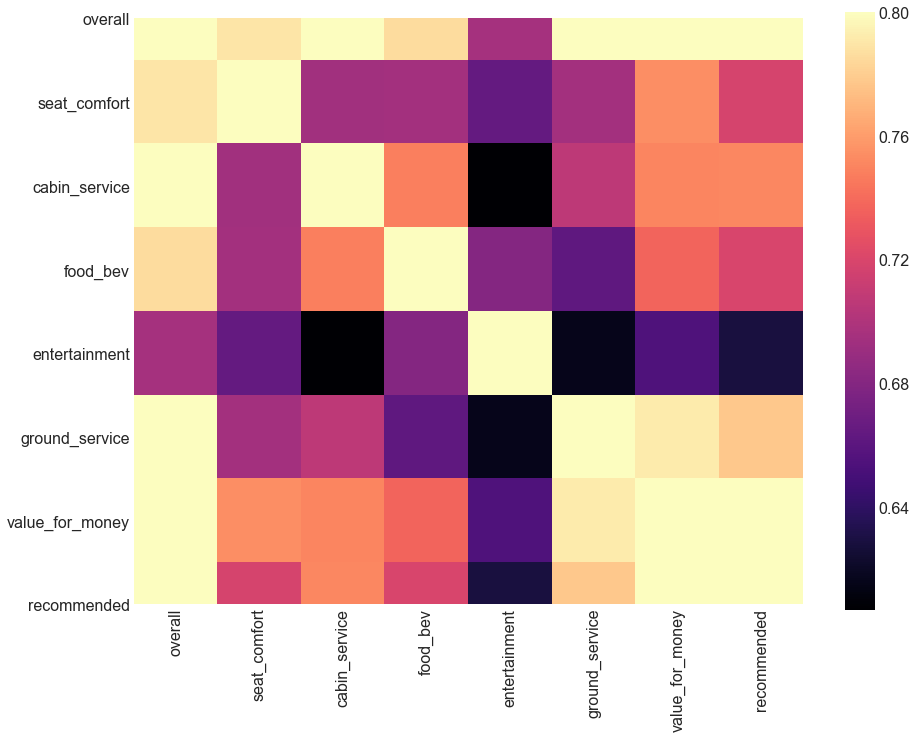

In [47]:
corr = df.corr()
plt.figure(figsize=(15, 11))
sns.heatmap(corr, vmax=.8, square=True, cmap='magma')

Затем посмотрим, в каких столбцах у нас есть пропуски и в каком количестве

In [48]:
clmns = df.columns[df.isnull().any()]
missed = pd.DataFrame(df[clmns].isnull().sum().sort_values(ascending=False) / df.shape[0], columns=['% NULL'])
missed

% NULL
aircraft         0.701002
ground_service   0.403187
traveller_type   0.397167
entertainment    0.329871
food_bev         0.202268
seat_comfort     0.079852
cabin_service    0.079336
cabin            0.040093
value_for_money  0.029903
overall          0.029266

Теперь обработаем категориальные параметры. Сделаем это вручную one-hot кодированием, потому что в них всех немного категорий (кроме aircraft, но об этом сейчас будет написано подробнее). Так мы сделаем эти параметры значимыми для модели, а также избавимся от пропусков в них (у тех строк, где были пропуски, просто будет 0 в этих столбцах)

In [49]:
cat_clmns = df.columns[df.dtypes == 'object']
df[cat_clmns].head()

aircraft  traveller_type          cabin
0      NaN        Business  Economy Class
1      NaN  Family Leisure  Economy Class
2      NaN        Business  Economy Class
3     A330    Solo Leisure  Economy Class
4      NaN    Solo Leisure  Economy Class

Начнём с обработки моделей самолётов. Рассмотрим, какие там есть варианты

In [50]:
skytrax_aircraft = skytrax.groupby('aircraft').size().reset_index(name='counts')

def aircraft(row):
    return row['counts'] / len(skytrax) * 100
    
skytrax_aircraft['%'] = skytrax_aircraft.apply(aircraft, axis=1)
skytrax_aircraft.sort_values('counts', inplace=True, ascending=False)
skytrax_aircraft = skytrax_aircraft.reset_index()
print(len(skytrax_aircraft))
skytrax_aircraft[:10]

2088


index          aircraft  counts         %
0    132              A320    2157  3.270808
1   1290        Boeing 777    1215  1.842389
2    651              A380    1109  1.681653
3    377              A330    1074  1.628581
4   1019    Boeing 737-800    1036  1.570958
5   1575        Boeing 787     934  1.416289
6   1487  Boeing 777-300ER     841  1.275267
7     73              A319     689  1.044778
8    289              A321     684  1.037197
9    942        Boeing 737     660  1.000804

Всего вариантов модели самолёта очень много, причем многие из них похожи друг на друга. Поэтому не будем разбивать этот параметр на все возможные варианты, а возьмем самые популярные модели и создадим вручную параметры только для них. Так мы не только создадим новые значимые параметры, но ещё и сможем объединить в них некоторые некорректно заполненные данные или те, в которых мы отбросим ненужные подробности о модели

In [51]:
def A320(row):
    if (row['aircraft'] != row['aircraft']):
        return 0
    if ((str(row['aircraft']).find("A320") != -1) or (str(row['aircraft']).find("A319") != -1) or (str(row['aircraft']).find("A321") != -1)):
        return 1
    else:
        return 0
    
def Boeing777(row):
    if (row['aircraft'] != row['aircraft']):
        return 0
    if (str(row['aircraft']).find("Boeing 777") != -1):
        return 1
    else:
        return 0

def A380(row):
    if (row['aircraft'] != row['aircraft']):
        return 0
    if (str(row['aircraft']).find("A380") != -1):
        return 1
    else:
        return 0
    
def A330(row):
    if (row['aircraft'] != row['aircraft']):
        return 0
    if (str(row['aircraft']).find("A330") != -1):
        return 1
    else:
        return 0
    
def Boeing737(row):
    if (row['aircraft'] != row['aircraft']):
        return 0
    if (str(row['aircraft']).find("Boeing 737") != -1):
        return 1
    else:
        return 0

def Boeing787(row):
    if (row['aircraft'] != row['aircraft']):
        return 0
    if (str(row['aircraft']).find("Boeing 787") != -1):
        return 1
    else:
        return 0

df['A320'] = df.apply(A320, axis=1)
df['Boeing777'] = df.apply(Boeing777, axis=1)
df['A380'] = df.apply(A380, axis=1)
df['A330'] = df.apply(A330, axis=1)
df['Boeing737'] = df.apply(Boeing737, axis=1)
df['Boeing787'] = df.apply(Boeing787, axis=1)

del df['aircraft']

df.head()

overall  traveller_type          cabin  seat_comfort  cabin_service  \
0      7.0        Business  Economy Class           4.0            5.0   
1      2.0  Family Leisure  Economy Class           4.0            1.0   
2      3.0        Business  Economy Class           1.0            4.0   
3     10.0    Solo Leisure  Economy Class           4.0            5.0   
4      1.0    Solo Leisure  Economy Class           1.0            1.0   

   food_bev  entertainment  ground_service  value_for_money  recommended  \
0       4.0            4.0             2.0              4.0            1   
1       1.0            1.0             1.0              1.0            0   
2       1.0            3.0             1.0              2.0            0   
3       5.0            5.0             5.0              5.0            1   
4       1.0            1.0             1.0              1.0            0   

   A320  Boeing777  A380  A330  Boeing737  Boeing787  
0     0          0     0     0          0          0  
1     0          0     0     0          0          0  
2     0          0     0     0          0          0  
3     0          0     0     1          0          0  
4     0          0     0     0          0          0

Теперь перейдём к остальным категориальным параметрам, там ситуация проще

In [52]:
set(df['traveller_type'])

{'Business', 'Couple Leisure', 'Family Leisure', 'Solo Leisure', nan}

In [53]:
set(df['cabin'])

{'Business Class', 'Economy Class', 'First Class', 'Premium Economy', nan}

In [54]:
def business_type(row):
    if (row['traveller_type'] == "Business"):
        return 1
    else:
        return 0
    
def couple(row):
    if (row['traveller_type'] == "Couple Leisure"):
        return 1
    else:
        return 0

def family(row):
    if (row['traveller_type'] == "Family Leisure"):
        return 1
    else:
        return 0
            
def solo(row):
    if (row['traveller_type'] == "Solo Leisure"):
        return 1
    else:
        return 0

df['business_type'] = df.apply(business_type, axis=1)
df['couple'] = df.apply(couple, axis=1)
df['family'] = df.apply(family, axis=1)
df['solo'] = df.apply(solo, axis=1)

del df['traveller_type']

df.head()

overall          cabin  seat_comfort  cabin_service  food_bev  \
0      7.0  Economy Class           4.0            5.0       4.0   
1      2.0  Economy Class           4.0            1.0       1.0   
2      3.0  Economy Class           1.0            4.0       1.0   
3     10.0  Economy Class           4.0            5.0       5.0   
4      1.0  Economy Class           1.0            1.0       1.0   

   entertainment  ground_service  value_for_money  recommended  A320  \
0            4.0             2.0              4.0            1     0   
1            1.0             1.0              1.0            0     0   
2            3.0             1.0              2.0            0     0   
3            5.0             5.0              5.0            1     0   
4            1.0             1.0              1.0            0     0   

   Boeing777  A380  A330  Boeing737  Boeing787  business_type  couple  family  \
0          0     0     0          0          0              1       0       0   
1          0     0     0          0          0              0       0       1   
2          0     0     0          0          0              1       0       0   
3          0     0     1          0          0              0       0       0   
4          0     0     0          0          0              0       0       0   

   solo  
0     0  
1     0  
2     0  
3     1  
4     1

In [55]:
def business_class(row):
    if (row['cabin'] == "Business Class"):
        return 1
    else:
        return 0
    
def economy_class(row):
    if (row['cabin'] == "Economy Class"):
        return 1
    else:
        return 0

def first_class(row):
    if (row['cabin'] == "First Class"):
        return 1
    else:
        return 0
            
def prem_economy_class(row):
    if (row['cabin'] == "Premium Economy"):
        return 1
    else:
        return 0

df['business_class'] = df.apply(business_class, axis=1)
df['economy_class'] = df.apply(economy_class, axis=1)
df['first_class'] = df.apply(first_class, axis=1)
df['prem_economy_class'] = df.apply(prem_economy_class, axis=1)

del df['cabin']

df.head()

overall  seat_comfort  cabin_service  food_bev  entertainment  \
0      7.0           4.0            5.0       4.0            4.0   
1      2.0           4.0            1.0       1.0            1.0   
2      3.0           1.0            4.0       1.0            3.0   
3     10.0           4.0            5.0       5.0            5.0   
4      1.0           1.0            1.0       1.0            1.0   

   ground_service  value_for_money  recommended  A320  Boeing777  ...  \
0             2.0              4.0            1     0          0  ...   
1             1.0              1.0            0     0          0  ...   
2             1.0              2.0            0     0          0  ...   
3             5.0              5.0            1     0          0  ...   
4             1.0              1.0            0     0          0  ...   

   Boeing737  Boeing787  business_type  couple  family  solo  business_class  \
0          0          0              1       0       0     0               0   
1          0          0              0       0       1     0               0   
2          0          0              1       0       0     0               0   
3          0          0              0       0       0     1               0   
4          0          0              0       0       0     1               0   

   economy_class  first_class  prem_economy_class  
0              1            0                   0  
1              1            0                   0  
2              1            0                   0  
3              1            0                   0  
4              1            0                   0  

[5 rows x 22 columns]

На всякий случай ещё раз посмотрим на корелляцию

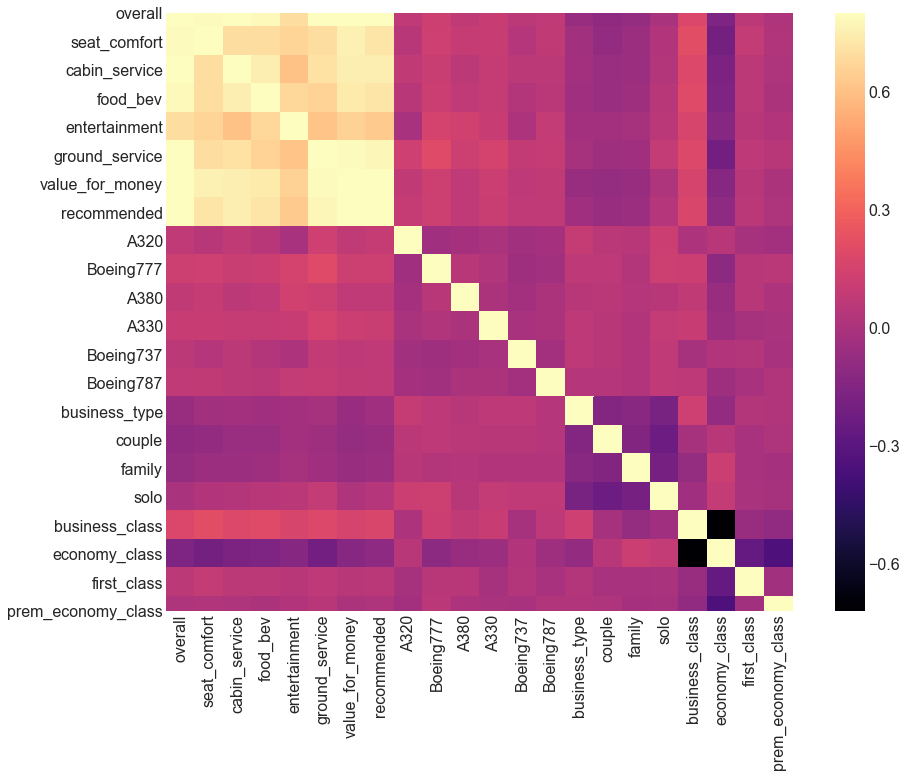

In [56]:
corr = df.corr()
plt.figure(figsize=(15, 11))
sns.heatmap(corr, vmax=.8, square=True, cmap='magma')

Убедимся, что пропуски остались только в числовых параметрах

In [57]:
clmns = df.columns[df.isnull().any()]
missed = pd.DataFrame(df[clmns].isnull().sum().sort_values(ascending=False) / df.shape[0], columns=['% NULL'])
missed

% NULL
ground_service   0.403187
entertainment    0.329871
food_bev         0.202268
seat_comfort     0.079852
cabin_service    0.079336
value_for_money  0.029903
overall          0.029266

И заполним их медианными значениями

In [58]:
fill = df.apply(lambda s: s.mode()[0] if s.dtype == 'object' else s.median(), axis=0)
df = df.fillna(value=fill)

Теперь, когда с предобработкой окончено, перейдём к самому предсказанию. Я заметил, что можно попробовать предсказать отдельно суммарную оценку (overall) и то, рекомендует человек авиакомпанию или нет (recommended). Это и проделаем

In [59]:
y = df['overall']

In [60]:
X = df.copy()
del X['overall']
del X['recommended']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Для предсказания общей десятибальной оценки будем использовать линейную регрессию. Точность посчитаем по R2

In [62]:
lr = LinearRegression()
lr.fit(x_train, y_train)

test_p = lr.predict(x_test)
print('Test R2 %.3f\n' % r2_score(y_test, test_p))

Test R2 0.827



In [63]:
print(lr.coef_)

[ 0.30305748  0.36678423  0.2283083   0.12416473  0.39339426  1.04085887
  0.21451791  0.08795063  0.0880591  -0.01505323  0.20560461  0.07433036
 -0.50884338 -0.49583796 -0.52863518 -0.5059585   0.4440992   0.37980854
  0.4355858   0.39678066]


In [64]:
for i in range(len(X.columns)):
    print(X.columns[i], '%.3f' %lr.coef_[i])

seat_comfort 0.303
cabin_service 0.367
food_bev 0.228
entertainment 0.124
ground_service 0.393
value_for_money 1.041
A320 0.215
Boeing777 0.088
A380 0.088
A330 -0.015
Boeing737 0.206
Boeing787 0.074
business_type -0.509
couple -0.496
family -0.529
solo -0.506
business_class 0.444
economy_class 0.380
first_class 0.436
prem_economy_class 0.397


In [65]:
for i in range(len(X.columns)):
    print(X.columns[i])

seat_comfort
cabin_service
food_bev
entertainment
ground_service
value_for_money
A320
Boeing777
A380
A330
Boeing737
Boeing787
business_type
couple
family
solo
business_class
economy_class
first_class
prem_economy_class


In [66]:
stats.summary(lr, x_train, y_train)

Residuals:
   Min      1Q  Median      3Q     Max
-9.873 -0.8212 -0.1004  0.7528  8.9334


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept -2.220390    0.032377  -68.5783  0.000000
x1          0.303057    0.007416   40.8649  0.000000
x2          0.366784    0.006829   53.7066  0.000000
x3          0.228308    0.007303   31.2613  0.000000
x4          0.124165    0.006539   18.9874  0.000000
x5          0.393394    0.006566   59.9169  0.000000
x6          1.040859    0.007051  147.6197  0.000000
x7          0.214518    0.027110    7.9128  0.000000
x8          0.087951    0.029203    3.0117  0.002599
x9          0.088059    0.042609    2.0667  0.038771
x10        -0.015053    0.035046   -0.4295  0.667538
x11         0.205605    0.037496    5.4834  0.000000
x12         0.074330    0.043932    1.6919  0.090665
x13        -0.508843    0.023934  -21.2604  0.000000
x14        -0.495838    0.020475  -24.2165  0.000000
x15        -0.528635    0.022981  -23.0029  0.0

/opt/anaconda3/lib/python3.7/site-packages/regressors/stats.py:144: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/regressors/stats.py:144: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/nump

А вероятность рекомендации предскажем с помощью логистической регрессии. В качестве меры точности посчитаем precision

In [67]:
y = df['recommended']

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = LogisticRegression()
lr.fit(x_train, y_train)

test_p = lr.predict(x_test)
print('Test Precision %.3f\n' %precision_score(y_test, test_p, average='macro'))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Test Precision 0.938



In [69]:
p = stats.coef_pval(lr, x_train, y_train)
print('%18s  %18s  %18s' %("feature", "coef", "p-value"))
for i in range(len(X.columns)):
    print('%18s  %18s  %18s' %(X.columns[i], '%.3f' %math.exp(lr.coef_[0][i]), '%.3f' %p[i]))

           feature                coef             p-value
      seat_comfort               1.600               0.000
     cabin_service               2.013               0.000
          food_bev               1.439               0.000
     entertainment               1.228               0.000
    ground_service               1.948               0.000
   value_for_money               4.705               0.000
              A320               2.376               0.000
         Boeing777               1.133               0.000
              A380               0.999               0.000
              A330               1.207               0.874
         Boeing737               2.041               0.000
         Boeing787               1.523               0.000
     business_type               0.836               0.000
            couple               0.616               0.000
            family               0.630               0.000
              solo               0.842               0.0

/opt/anaconda3/lib/python3.7/site-packages/regressors/stats.py:144: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/regressors/stats.py:144: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/nump

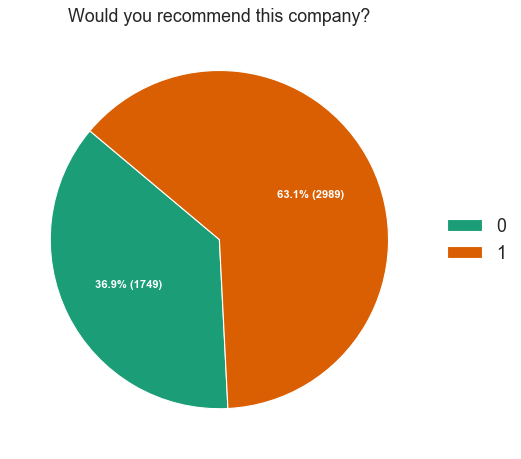

In [70]:
dff = df[df['A320'] == 1].groupby('recommended').size().reset_index(name='counts')

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = dff['counts']
categories = dff['recommended']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140)

ax.legend(wedges, categories, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Would you recommend this company?")
plt.show()

Результаты получились очень хорошие даже у простых моделей. Возможно, потому что в данных было много корреляций

## 3) Анкетирование
Данные: https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction

В целом столбцы похожи на те, что были у Skytrax, только с большим количеством информации о пассажирах (возраст, пол), а также более подробными характеристиками полета (большее количество параметров оценок, а также задержка в минутах и длина рейса в километрах)

In [71]:
survey_train = pd.read_csv('train.csv')
survey_test = pd.read_csv('test.csv')

survey_train.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   
4                                  3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 25 columns]

Посмотрим корелляцию признаков

In [72]:
survey_train.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.



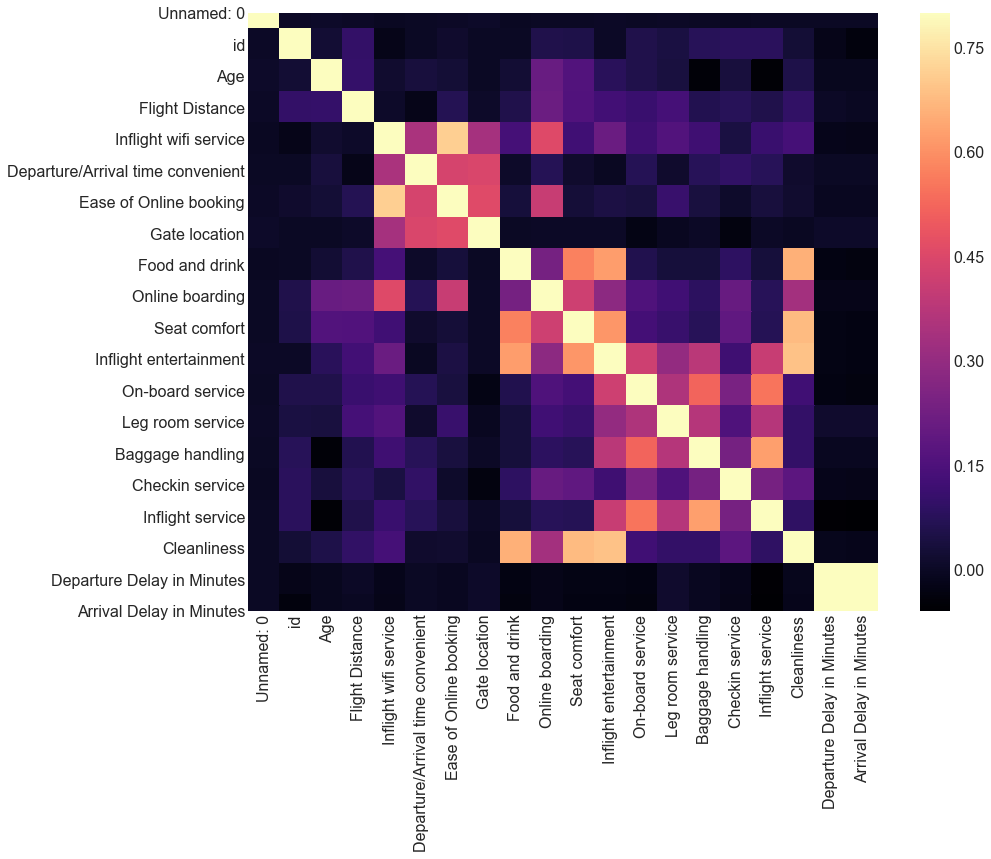

In [73]:
corr = survey_train.corr()
plt.figure(figsize=(15, 11))
sns.heatmap(corr, vmax=.8, square=True, cmap='magma')

Склеим пока тест и трейн, чтобы обработать все признаки

In [74]:
survey = pd.concat([survey_train, survey_test], ignore_index=True)
survey.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   
4                                  3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 25 columns]

In [75]:
del survey['Unnamed: 0']
del survey['id']

Обработаем опять таки категориальные признаки в нужный нам формат

In [76]:
cat_clmns = survey.columns[survey.dtypes == 'object']
survey[cat_clmns].head()

Gender      Customer Type   Type of Travel     Class  \
0    Male     Loyal Customer  Personal Travel  Eco Plus   
1    Male  disloyal Customer  Business travel  Business   
2  Female     Loyal Customer  Business travel  Business   
3  Female     Loyal Customer  Business travel  Business   
4    Male     Loyal Customer  Business travel  Business   

              satisfaction  
0  neutral or dissatisfied  
1  neutral or dissatisfied  
2                satisfied  
3  neutral or dissatisfied  
4                satisfied

In [77]:
set(survey['Gender'])

{'Female', 'Male'}

In [78]:
set(survey['Customer Type'])

{'Loyal Customer', 'disloyal Customer'}

In [79]:
set(survey['Type of Travel'])

{'Business travel', 'Personal Travel'}

In [80]:
set(survey['Class'])

{'Business', 'Eco', 'Eco Plus'}

In [81]:
set(survey['satisfaction'])

{'neutral or dissatisfied', 'satisfied'}

In [82]:
def female(row):
    if (row['Gender'] == "Female"):
        return 1
    else:
        return 0
    
def male(row):
    if (row['Gender'] == "Male"):
        return 1
    else:
        return 0

survey['male'] = survey.apply(female, axis=1)
survey['female'] = survey.apply(male, axis=1)

del survey['Gender']

survey.head()

Customer Type  Age   Type of Travel     Class  Flight Distance  \
0     Loyal Customer   13  Personal Travel  Eco Plus              460   
1  disloyal Customer   25  Business travel  Business              235   
2     Loyal Customer   26  Business travel  Business             1142   
3     Loyal Customer   25  Business travel  Business              562   
4     Loyal Customer   61  Business travel  Business              214   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      3                                  4   
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   

   Ease of Online booking  Gate location  Food and drink  ...  \
0                       3              1               5  ...   
1                       3              3               1  ...   
2                       2              2               5  ...   
3                       5              5               2  ...   
4                       3              3               4  ...   

   Leg room service  Baggage handling  Checkin service  Inflight service  \
0                 3                 4                4                 5   
1                 5                 3                1                 4   
2                 3                 4                4                 4   
3                 5                 3                1                 4   
4                 4                 4                3                 3   

   Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
0            5                          25                      18.0   
1            1                           1                       6.0   
2            5                           0                       0.0   
3            2                          11                       9.0   
4            3                           0                       0.0   

              satisfaction  male  female  
0  neutral or dissatisfied     0       1  
1  neutral or dissatisfied     0       1  
2                satisfied     1       0  
3  neutral or dissatisfied     1       0  
4                satisfied     0       1  

[5 rows x 24 columns]

In [83]:
def loyal(row):
    if (row['Customer Type'] == "Loyal Customer"):
        return 1
    else:
        return 0
    
def disloyal(row):
    if (row['Customer Type'] == "disloyal Customer"):
        return 1
    else:
        return 0

survey['loyal'] = survey.apply(loyal, axis=1)
survey['disloyal'] = survey.apply(disloyal, axis=1)

del survey['Customer Type']

survey.head()

Age   Type of Travel     Class  Flight Distance  Inflight wifi service  \
0   13  Personal Travel  Eco Plus              460                      3   
1   25  Business travel  Business              235                      3   
2   26  Business travel  Business             1142                      2   
3   25  Business travel  Business              562                      2   
4   61  Business travel  Business              214                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  ...  Checkin service  Inflight service  \
0               5                3  ...                4                 5   
1               1                3  ...                1                 4   
2               5                5  ...                4                 4   
3               2                2  ...                1                 4   
4               4                5  ...                3                 3   

   Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
0            5                          25                      18.0   
1            1                           1                       6.0   
2            5                           0                       0.0   
3            2                          11                       9.0   
4            3                           0                       0.0   

              satisfaction  male  female  loyal  disloyal  
0  neutral or dissatisfied     0       1      1         0  
1  neutral or dissatisfied     0       1      0         1  
2                satisfied     1       0      1         0  
3  neutral or dissatisfied     1       0      1         0  
4                satisfied     0       1      1         0  

[5 rows x 25 columns]

In [84]:
def business_type(row):
    if (row['Type of Travel'] == "Business travel"):
        return 1
    else:
        return 0
    
def personal(row):
    if (row['Type of Travel'] == "Personal Travel"):
        return 1
    else:
        return 0

survey['business_type'] = survey.apply(business_type, axis=1)
survey['personal'] = survey.apply(personal, axis=1)

del survey['Type of Travel']

survey.head()

Age     Class  Flight Distance  Inflight wifi service  \
0   13  Eco Plus              460                      3   
1   25  Business              235                      3   
2   26  Business             1142                      2   
3   25  Business              562                      2   
4   61  Business              214                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  ...  Cleanliness  \
0               5                3             5  ...            5   
1               1                3             1  ...            1   
2               5                5             5  ...            5   
3               2                2             2  ...            2   
4               4                5             5  ...            3   

   Departure Delay in Minutes  Arrival Delay in Minutes  \
0                          25                      18.0   
1                           1                       6.0   
2                           0                       0.0   
3                          11                       9.0   
4                           0                       0.0   

              satisfaction  male  female  loyal  disloyal  business_type  \
0  neutral or dissatisfied     0       1      1         0              0   
1  neutral or dissatisfied     0       1      0         1              1   
2                satisfied     1       0      1         0              1   
3  neutral or dissatisfied     1       0      1         0              1   
4                satisfied     0       1      1         0              1   

  personal  
0        1  
1        0  
2        0  
3        0  
4        0  

[5 rows x 26 columns]

In [85]:
def business_class(row):
    if (row['Class'] == "Business"):
        return 1
    else:
        return 0
    
def eco(row):
    if (row['Class'] == "Eco"):
        return 1
    else:
        return 0

def eco_plus(row):
    if (row['Class'] == "Eco Plus"):
        return 1
    else:
        return 0

survey['business_class'] = survey.apply(business_class, axis=1)
survey['eco'] = survey.apply(eco, axis=1)
survey['eco_plus'] = survey.apply(eco_plus, axis=1)

del survey['Class']

survey.head()

Age  Flight Distance  Inflight wifi service  \
0   13              460                      3   
1   25              235                      3   
2   26             1142                      2   
3   25              562                      2   
4   61              214                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...  \
0               5                3             5                       5  ...   
1               1                3             1                       1  ...   
2               5                5             5                       5  ...   
3               2                2             2                       2  ...   
4               4                5             5                       3  ...   

              satisfaction  male  female  loyal  disloyal  business_type  \
0  neutral or dissatisfied     0       1      1         0              0   
1  neutral or dissatisfied     0       1      0         1              1   
2                satisfied     1       0      1         0              1   
3  neutral or dissatisfied     1       0      1         0              1   
4                satisfied     0       1      1         0              1   

   personal  business_class eco  eco_plus  
0         1               0   0         1  
1         0               1   0         0  
2         0               1   0         0  
3         0               1   0         0  
4         0               1   0         0  

[5 rows x 28 columns]

In [86]:
def satisfaction(row):
    if (row['satisfaction'] == "satisfied"):
        return 1
    else:
        return 0
    
survey['satisfaction'] = survey.apply(satisfaction, axis=1)

survey.head()

Age  Flight Distance  Inflight wifi service  \
0   13              460                      3   
1   25              235                      3   
2   26             1142                      2   
3   25              562                      2   
4   61              214                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...  \
0               5                3             5                       5  ...   
1               1                3             1                       1  ...   
2               5                5             5                       5  ...   
3               2                2             2                       2  ...   
4               4                5             5                       3  ...   

   satisfaction  male  female  loyal  disloyal  business_type  personal  \
0             0     0       1      1         0              0         1   
1             0     0       1      0         1              1         0   
2             1     1       0      1         0              1         0   
3             0     1       0      1         0              1         0   
4             1     0       1      1         0              1         0   

   business_class  eco  eco_plus  
0               0    0         1  
1               1    0         0  
2               1    0         0  
3               1    0         0  
4               1    0         0  

[5 rows x 28 columns]

Посмотрим, остались ли где-то ещё пробелы в данных

In [87]:
clmns = survey.columns[survey.isnull().any()]
missed = pd.DataFrame(survey[clmns].isnull().sum().sort_values(ascending=False) / survey.shape[0], columns=['% NULL'])
missed

% NULL
Arrival Delay in Minutes  0.003026

Заполним их медианными данными

In [88]:
fill = survey.apply(lambda s: s.mode()[0] if s.dtype == 'object' else s.median(), axis=0)
survey = survey.fillna(value=fill)

А вот теперь сделаем сами модели. Предсказывать опять таки будем общую удовлетворённость, которая у нас в формате yes/no (0/1)

In [89]:
y = survey['satisfaction']
X = survey.copy()
del X['satisfaction']

Начнём с логистической регрессии. Результат precision неплохой, но можно получить лучше

In [90]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = LogisticRegression()
lr.fit(x_train, y_train)

test_p = lr.predict(x_test)
print('Test Precision %.3f\n' %precision_score(y_test, test_p, average='macro'))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Test Precision 0.872



In [91]:
p = stats.coef_pval(lr, x_train, y_train)
print('%26s  %26s  %26s' %("feature", "coef", "p-value"))
for i in range(len(X.columns)):
    print('%26s  %26s  %26s' %(X.columns[i], '%.3f' %math.exp(lr.coef_[0][i]), '%.3f' %p[i]))

                   feature                        coef                     p-value
                       Age                       0.992                       1.000
           Flight Distance                       1.000                       0.000
     Inflight wifi service                       1.511                       0.944
Departure/Arrival time convenient                       0.884                       0.000
    Ease of Online booking                       0.836                       0.000
             Gate location                       1.029                       0.000
            Food and drink                       0.970                       0.000
           Online boarding                       1.829                       0.000
              Seat comfort                       1.080                       0.000
    Inflight entertainment                       1.058                       0.000
          On-board service                       1.373                       0.0

/opt/anaconda3/lib/python3.7/site-packages/regressors/stats.py:144: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/regressors/stats.py:144: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/opt/anaconda3/lib/python3.7/site-packages/nump

Перейдём к более сложным моделям, попробуем catboost с некоторыми большими параметрами

In [92]:
model = cb.CatBoostRegressor(iterations=5000, depth=7)

model.fit(x_train, y_train)

test_p = model.predict(x_test)

Learning rate set to 0.025435
0:	learn: 0.4864278	total: 73.1ms	remaining: 6m 5s
1:	learn: 0.4775259	total: 87.4ms	remaining: 3m 38s
2:	learn: 0.4688819	total: 102ms	remaining: 2m 49s
3:	learn: 0.4602244	total: 117ms	remaining: 2m 26s
4:	learn: 0.4519748	total: 132ms	remaining: 2m 12s
5:	learn: 0.4438548	total: 147ms	remaining: 2m 2s
6:	learn: 0.4362476	total: 162ms	remaining: 1m 55s
7:	learn: 0.4287983	total: 180ms	remaining: 1m 52s
8:	learn: 0.4214202	total: 252ms	remaining: 2m 19s
9:	learn: 0.4145418	total: 285ms	remaining: 2m 22s
10:	learn: 0.4077420	total: 303ms	remaining: 2m 17s
11:	learn: 0.4013128	total: 319ms	remaining: 2m 12s
12:	learn: 0.3950360	total: 335ms	remaining: 2m 8s
13:	learn: 0.3889236	total: 350ms	remaining: 2m 4s
14:	learn: 0.3830505	total: 365ms	remaining: 2m 1s
15:	learn: 0.3771754	total: 384ms	remaining: 1m 59s
16:	learn: 0.3716679	total: 440ms	remaining: 2m 9s
17:	learn: 0.3663306	total: 482ms	remaining: 2m 13s
18:	learn: 0.3611776	total: 500ms	remaining: 2m 

162:	learn: 0.1991967	total: 3.62s	remaining: 1m 47s
163:	learn: 0.1990634	total: 3.64s	remaining: 1m 47s
164:	learn: 0.1988856	total: 3.67s	remaining: 1m 47s
165:	learn: 0.1987546	total: 3.69s	remaining: 1m 47s
166:	learn: 0.1986705	total: 3.69s	remaining: 1m 46s
167:	learn: 0.1985731	total: 3.71s	remaining: 1m 46s
168:	learn: 0.1984996	total: 3.71s	remaining: 1m 46s
169:	learn: 0.1983482	total: 3.73s	remaining: 1m 45s
170:	learn: 0.1982137	total: 3.74s	remaining: 1m 45s
171:	learn: 0.1981603	total: 3.75s	remaining: 1m 45s
172:	learn: 0.1980680	total: 3.76s	remaining: 1m 44s
173:	learn: 0.1979521	total: 3.77s	remaining: 1m 44s
174:	learn: 0.1978489	total: 3.78s	remaining: 1m 44s
175:	learn: 0.1976247	total: 3.79s	remaining: 1m 43s
176:	learn: 0.1975606	total: 3.8s	remaining: 1m 43s
177:	learn: 0.1975188	total: 3.81s	remaining: 1m 43s
178:	learn: 0.1974494	total: 3.82s	remaining: 1m 42s
179:	learn: 0.1973468	total: 3.85s	remaining: 1m 42s
180:	learn: 0.1972395	total: 3.86s	remaining: 1

326:	learn: 0.1854177	total: 6.07s	remaining: 1m 26s
327:	learn: 0.1853674	total: 6.09s	remaining: 1m 26s
328:	learn: 0.1852845	total: 6.11s	remaining: 1m 26s
329:	learn: 0.1852239	total: 6.14s	remaining: 1m 26s
330:	learn: 0.1851368	total: 6.16s	remaining: 1m 26s
331:	learn: 0.1850664	total: 6.18s	remaining: 1m 26s
332:	learn: 0.1849894	total: 6.2s	remaining: 1m 26s
333:	learn: 0.1849221	total: 6.22s	remaining: 1m 26s
334:	learn: 0.1848698	total: 6.24s	remaining: 1m 26s
335:	learn: 0.1848105	total: 6.26s	remaining: 1m 26s
336:	learn: 0.1847628	total: 6.33s	remaining: 1m 27s
337:	learn: 0.1847280	total: 6.35s	remaining: 1m 27s
338:	learn: 0.1846679	total: 6.37s	remaining: 1m 27s
339:	learn: 0.1846028	total: 6.39s	remaining: 1m 27s
340:	learn: 0.1845377	total: 6.42s	remaining: 1m 27s
341:	learn: 0.1844817	total: 6.45s	remaining: 1m 27s
342:	learn: 0.1844277	total: 6.47s	remaining: 1m 27s
343:	learn: 0.1844030	total: 6.49s	remaining: 1m 27s
344:	learn: 0.1843604	total: 6.51s	remaining: 1

484:	learn: 0.1785130	total: 9.96s	remaining: 1m 32s
485:	learn: 0.1784679	total: 9.99s	remaining: 1m 32s
486:	learn: 0.1784481	total: 10s	remaining: 1m 32s
487:	learn: 0.1784222	total: 10s	remaining: 1m 32s
488:	learn: 0.1783987	total: 10.1s	remaining: 1m 32s
489:	learn: 0.1783905	total: 10.1s	remaining: 1m 32s
490:	learn: 0.1783692	total: 10.1s	remaining: 1m 32s
491:	learn: 0.1783235	total: 10.1s	remaining: 1m 32s
492:	learn: 0.1782439	total: 10.1s	remaining: 1m 32s
493:	learn: 0.1782315	total: 10.2s	remaining: 1m 32s
494:	learn: 0.1781975	total: 10.2s	remaining: 1m 32s
495:	learn: 0.1781816	total: 10.2s	remaining: 1m 32s
496:	learn: 0.1781559	total: 10.2s	remaining: 1m 32s
497:	learn: 0.1781384	total: 10.3s	remaining: 1m 32s
498:	learn: 0.1781205	total: 10.3s	remaining: 1m 32s
499:	learn: 0.1780776	total: 10.3s	remaining: 1m 32s
500:	learn: 0.1780354	total: 10.3s	remaining: 1m 32s
501:	learn: 0.1780163	total: 10.3s	remaining: 1m 32s
502:	learn: 0.1779945	total: 10.3s	remaining: 1m 3

651:	learn: 0.1742372	total: 13s	remaining: 1m 26s
652:	learn: 0.1742274	total: 13s	remaining: 1m 26s
653:	learn: 0.1742127	total: 13s	remaining: 1m 26s
654:	learn: 0.1742002	total: 13s	remaining: 1m 26s
655:	learn: 0.1741704	total: 13.1s	remaining: 1m 26s
656:	learn: 0.1741486	total: 13.1s	remaining: 1m 26s
657:	learn: 0.1741353	total: 13.1s	remaining: 1m 26s
658:	learn: 0.1741109	total: 13.1s	remaining: 1m 26s
659:	learn: 0.1740914	total: 13.1s	remaining: 1m 26s
660:	learn: 0.1740814	total: 13.1s	remaining: 1m 26s
661:	learn: 0.1740442	total: 13.1s	remaining: 1m 25s
662:	learn: 0.1740318	total: 13.1s	remaining: 1m 25s
663:	learn: 0.1740112	total: 13.1s	remaining: 1m 25s
664:	learn: 0.1739796	total: 13.1s	remaining: 1m 25s
665:	learn: 0.1739733	total: 13.2s	remaining: 1m 25s
666:	learn: 0.1739467	total: 13.2s	remaining: 1m 25s
667:	learn: 0.1739348	total: 13.2s	remaining: 1m 25s
668:	learn: 0.1739067	total: 13.2s	remaining: 1m 25s
669:	learn: 0.1738832	total: 13.2s	remaining: 1m 25s
6

816:	learn: 0.1713086	total: 15.1s	remaining: 1m 17s
817:	learn: 0.1713019	total: 15.1s	remaining: 1m 17s
818:	learn: 0.1712842	total: 15.1s	remaining: 1m 17s
819:	learn: 0.1712461	total: 15.1s	remaining: 1m 17s
820:	learn: 0.1712264	total: 15.1s	remaining: 1m 17s
821:	learn: 0.1711968	total: 15.1s	remaining: 1m 16s
822:	learn: 0.1711922	total: 15.1s	remaining: 1m 16s
823:	learn: 0.1711704	total: 15.2s	remaining: 1m 16s
824:	learn: 0.1711591	total: 15.2s	remaining: 1m 16s
825:	learn: 0.1711372	total: 15.2s	remaining: 1m 16s
826:	learn: 0.1711196	total: 15.2s	remaining: 1m 16s
827:	learn: 0.1711141	total: 15.2s	remaining: 1m 16s
828:	learn: 0.1710898	total: 15.2s	remaining: 1m 16s
829:	learn: 0.1710681	total: 15.2s	remaining: 1m 16s
830:	learn: 0.1710526	total: 15.2s	remaining: 1m 16s
831:	learn: 0.1710482	total: 15.2s	remaining: 1m 16s
832:	learn: 0.1710400	total: 15.3s	remaining: 1m 16s
833:	learn: 0.1710309	total: 15.3s	remaining: 1m 16s
834:	learn: 0.1710147	total: 15.3s	remaining: 

983:	learn: 0.1687439	total: 17.1s	remaining: 1m 9s
984:	learn: 0.1687397	total: 17.2s	remaining: 1m 9s
985:	learn: 0.1687222	total: 17.2s	remaining: 1m 9s
986:	learn: 0.1687141	total: 17.2s	remaining: 1m 10s
987:	learn: 0.1686929	total: 17.2s	remaining: 1m 9s
988:	learn: 0.1686827	total: 17.2s	remaining: 1m 9s
989:	learn: 0.1686739	total: 17.3s	remaining: 1m 9s
990:	learn: 0.1686500	total: 17.3s	remaining: 1m 9s
991:	learn: 0.1686427	total: 17.3s	remaining: 1m 9s
992:	learn: 0.1686292	total: 17.3s	remaining: 1m 9s
993:	learn: 0.1686066	total: 17.3s	remaining: 1m 9s
994:	learn: 0.1685979	total: 17.3s	remaining: 1m 9s
995:	learn: 0.1685831	total: 17.4s	remaining: 1m 9s
996:	learn: 0.1685642	total: 17.4s	remaining: 1m 9s
997:	learn: 0.1685408	total: 17.4s	remaining: 1m 9s
998:	learn: 0.1685275	total: 17.4s	remaining: 1m 9s
999:	learn: 0.1685180	total: 17.4s	remaining: 1m 9s
1000:	learn: 0.1685030	total: 17.5s	remaining: 1m 9s
1001:	learn: 0.1684808	total: 17.5s	remaining: 1m 9s
1002:	lea

1144:	learn: 0.1666424	total: 19.2s	remaining: 1m 4s
1145:	learn: 0.1666272	total: 19.2s	remaining: 1m 4s
1146:	learn: 0.1666162	total: 19.2s	remaining: 1m 4s
1147:	learn: 0.1666075	total: 19.3s	remaining: 1m 4s
1148:	learn: 0.1665932	total: 19.3s	remaining: 1m 4s
1149:	learn: 0.1665808	total: 19.3s	remaining: 1m 4s
1150:	learn: 0.1665730	total: 19.3s	remaining: 1m 4s
1151:	learn: 0.1665655	total: 19.3s	remaining: 1m 4s
1152:	learn: 0.1665432	total: 19.3s	remaining: 1m 4s
1153:	learn: 0.1665256	total: 19.3s	remaining: 1m 4s
1154:	learn: 0.1665061	total: 19.3s	remaining: 1m 4s
1155:	learn: 0.1664979	total: 19.3s	remaining: 1m 4s
1156:	learn: 0.1664805	total: 19.4s	remaining: 1m 4s
1157:	learn: 0.1664752	total: 19.4s	remaining: 1m 4s
1158:	learn: 0.1664672	total: 19.4s	remaining: 1m 4s
1159:	learn: 0.1664526	total: 19.4s	remaining: 1m 4s
1160:	learn: 0.1664394	total: 19.4s	remaining: 1m 4s
1161:	learn: 0.1664306	total: 19.4s	remaining: 1m 4s
1162:	learn: 0.1664242	total: 19.4s	remaining:

1309:	learn: 0.1649417	total: 21.5s	remaining: 1m
1310:	learn: 0.1649272	total: 21.6s	remaining: 1m
1311:	learn: 0.1649164	total: 21.6s	remaining: 1m
1312:	learn: 0.1649051	total: 21.6s	remaining: 1m
1313:	learn: 0.1648961	total: 21.6s	remaining: 1m
1314:	learn: 0.1648816	total: 21.6s	remaining: 1m
1315:	learn: 0.1648664	total: 21.6s	remaining: 1m
1316:	learn: 0.1648528	total: 21.7s	remaining: 1m
1317:	learn: 0.1648475	total: 21.7s	remaining: 1m
1318:	learn: 0.1648414	total: 21.7s	remaining: 1m
1319:	learn: 0.1648311	total: 21.7s	remaining: 1m
1320:	learn: 0.1648166	total: 21.7s	remaining: 1m
1321:	learn: 0.1648128	total: 21.7s	remaining: 1m
1322:	learn: 0.1648064	total: 21.8s	remaining: 1m
1323:	learn: 0.1647953	total: 21.8s	remaining: 1m
1324:	learn: 0.1647905	total: 21.8s	remaining: 1m
1325:	learn: 0.1647819	total: 21.8s	remaining: 1m
1326:	learn: 0.1647751	total: 21.8s	remaining: 1m
1327:	learn: 0.1647612	total: 21.9s	remaining: 1m
1328:	learn: 0.1647512	total: 21.9s	remaining: 1m


1470:	learn: 0.1632688	total: 24.1s	remaining: 57.8s
1471:	learn: 0.1632561	total: 24.1s	remaining: 57.8s
1472:	learn: 0.1632415	total: 24.1s	remaining: 57.8s
1473:	learn: 0.1632342	total: 24.2s	remaining: 57.8s
1474:	learn: 0.1632232	total: 24.2s	remaining: 57.8s
1475:	learn: 0.1632099	total: 24.2s	remaining: 57.7s
1476:	learn: 0.1631962	total: 24.2s	remaining: 57.7s
1477:	learn: 0.1631836	total: 24.2s	remaining: 57.7s
1478:	learn: 0.1631672	total: 24.2s	remaining: 57.6s
1479:	learn: 0.1631598	total: 24.2s	remaining: 57.6s
1480:	learn: 0.1631466	total: 24.2s	remaining: 57.6s
1481:	learn: 0.1631364	total: 24.2s	remaining: 57.5s
1482:	learn: 0.1631321	total: 24.3s	remaining: 57.5s
1483:	learn: 0.1631235	total: 24.3s	remaining: 57.5s
1484:	learn: 0.1631122	total: 24.3s	remaining: 57.5s
1485:	learn: 0.1630996	total: 24.3s	remaining: 57.4s
1486:	learn: 0.1630951	total: 24.3s	remaining: 57.4s
1487:	learn: 0.1630850	total: 24.3s	remaining: 57.4s
1488:	learn: 0.1630731	total: 24.3s	remaining:

1628:	learn: 0.1617232	total: 26.7s	remaining: 55.2s
1629:	learn: 0.1617174	total: 26.7s	remaining: 55.1s
1630:	learn: 0.1617018	total: 26.7s	remaining: 55.1s
1631:	learn: 0.1616936	total: 26.7s	remaining: 55.1s
1632:	learn: 0.1616738	total: 26.7s	remaining: 55.1s
1633:	learn: 0.1616607	total: 26.7s	remaining: 55.1s
1634:	learn: 0.1616472	total: 26.7s	remaining: 55s
1635:	learn: 0.1616369	total: 26.7s	remaining: 55s
1636:	learn: 0.1616306	total: 26.8s	remaining: 55s
1637:	learn: 0.1616273	total: 26.8s	remaining: 54.9s
1638:	learn: 0.1616191	total: 26.8s	remaining: 54.9s
1639:	learn: 0.1616098	total: 26.8s	remaining: 54.9s
1640:	learn: 0.1616033	total: 26.8s	remaining: 54.9s
1641:	learn: 0.1615884	total: 26.8s	remaining: 54.8s
1642:	learn: 0.1615812	total: 26.8s	remaining: 54.8s
1643:	learn: 0.1615629	total: 26.8s	remaining: 54.8s
1644:	learn: 0.1615530	total: 26.8s	remaining: 54.7s
1645:	learn: 0.1615465	total: 26.9s	remaining: 54.7s
1646:	learn: 0.1615380	total: 26.9s	remaining: 54.7s

1785:	learn: 0.1603863	total: 29s	remaining: 52.1s
1786:	learn: 0.1603773	total: 29s	remaining: 52.1s
1787:	learn: 0.1603655	total: 29s	remaining: 52.1s
1788:	learn: 0.1603517	total: 29s	remaining: 52.1s
1789:	learn: 0.1603422	total: 29s	remaining: 52s
1790:	learn: 0.1603269	total: 29s	remaining: 52s
1791:	learn: 0.1603225	total: 29s	remaining: 52s
1792:	learn: 0.1603128	total: 29.1s	remaining: 52s
1793:	learn: 0.1603057	total: 29.1s	remaining: 51.9s
1794:	learn: 0.1602981	total: 29.1s	remaining: 51.9s
1795:	learn: 0.1602858	total: 29.1s	remaining: 51.9s
1796:	learn: 0.1602812	total: 29.1s	remaining: 51.9s
1797:	learn: 0.1602702	total: 29.1s	remaining: 51.8s
1798:	learn: 0.1602589	total: 29.1s	remaining: 51.8s
1799:	learn: 0.1602520	total: 29.1s	remaining: 51.8s
1800:	learn: 0.1602438	total: 29.1s	remaining: 51.8s
1801:	learn: 0.1602392	total: 29.1s	remaining: 51.7s
1802:	learn: 0.1602265	total: 29.2s	remaining: 51.7s
1803:	learn: 0.1602199	total: 29.2s	remaining: 51.7s
1804:	learn: 0.

1952:	learn: 0.1590419	total: 31s	remaining: 48.3s
1953:	learn: 0.1590387	total: 31s	remaining: 48.4s
1954:	learn: 0.1590356	total: 31s	remaining: 48.3s
1955:	learn: 0.1590248	total: 31s	remaining: 48.3s
1956:	learn: 0.1590235	total: 31.1s	remaining: 48.3s
1957:	learn: 0.1590207	total: 31.1s	remaining: 48.3s
1958:	learn: 0.1590088	total: 31.1s	remaining: 48.3s
1959:	learn: 0.1590000	total: 31.1s	remaining: 48.3s
1960:	learn: 0.1589905	total: 31.1s	remaining: 48.2s
1961:	learn: 0.1589832	total: 31.1s	remaining: 48.2s
1962:	learn: 0.1589799	total: 31.2s	remaining: 48.2s
1963:	learn: 0.1589767	total: 31.2s	remaining: 48.2s
1964:	learn: 0.1589721	total: 31.2s	remaining: 48.2s
1965:	learn: 0.1589643	total: 31.2s	remaining: 48.2s
1966:	learn: 0.1589581	total: 31.2s	remaining: 48.2s
1967:	learn: 0.1589476	total: 31.3s	remaining: 48.2s
1968:	learn: 0.1589434	total: 31.3s	remaining: 48.1s
1969:	learn: 0.1589416	total: 31.3s	remaining: 48.1s
1970:	learn: 0.1589404	total: 31.3s	remaining: 48.1s
1

2116:	learn: 0.1578263	total: 34s	remaining: 46.3s
2117:	learn: 0.1578240	total: 34s	remaining: 46.3s
2118:	learn: 0.1578139	total: 34s	remaining: 46.3s
2119:	learn: 0.1578098	total: 34s	remaining: 46.2s
2120:	learn: 0.1578006	total: 34s	remaining: 46.2s
2121:	learn: 0.1577911	total: 34.1s	remaining: 46.2s
2122:	learn: 0.1577902	total: 34.1s	remaining: 46.2s
2123:	learn: 0.1577771	total: 34.1s	remaining: 46.1s
2124:	learn: 0.1577717	total: 34.1s	remaining: 46.1s
2125:	learn: 0.1577661	total: 34.1s	remaining: 46.1s
2126:	learn: 0.1577613	total: 34.1s	remaining: 46.1s
2127:	learn: 0.1577512	total: 34.1s	remaining: 46.1s
2128:	learn: 0.1577452	total: 34.1s	remaining: 46s
2129:	learn: 0.1577404	total: 34.2s	remaining: 46s
2130:	learn: 0.1577342	total: 34.2s	remaining: 46s
2131:	learn: 0.1577310	total: 34.2s	remaining: 46s
2132:	learn: 0.1577176	total: 34.2s	remaining: 46s
2133:	learn: 0.1577106	total: 34.2s	remaining: 46s
2134:	learn: 0.1577035	total: 34.2s	remaining: 45.9s
2135:	learn: 0.

2280:	learn: 0.1567449	total: 36s	remaining: 42.9s
2281:	learn: 0.1567366	total: 36s	remaining: 42.9s
2282:	learn: 0.1567302	total: 36.1s	remaining: 42.9s
2283:	learn: 0.1567241	total: 36.1s	remaining: 42.9s
2284:	learn: 0.1567218	total: 36.1s	remaining: 42.9s
2285:	learn: 0.1567120	total: 36.1s	remaining: 42.8s
2286:	learn: 0.1567055	total: 36.1s	remaining: 42.8s
2287:	learn: 0.1566922	total: 36.1s	remaining: 42.8s
2288:	learn: 0.1566897	total: 36.1s	remaining: 42.8s
2289:	learn: 0.1566846	total: 36.1s	remaining: 42.8s
2290:	learn: 0.1566813	total: 36.2s	remaining: 42.7s
2291:	learn: 0.1566777	total: 36.2s	remaining: 42.7s
2292:	learn: 0.1566764	total: 36.2s	remaining: 42.7s
2293:	learn: 0.1566616	total: 36.2s	remaining: 42.7s
2294:	learn: 0.1566562	total: 36.2s	remaining: 42.7s
2295:	learn: 0.1566378	total: 36.2s	remaining: 42.6s
2296:	learn: 0.1566300	total: 36.2s	remaining: 42.6s
2297:	learn: 0.1566242	total: 36.2s	remaining: 42.6s
2298:	learn: 0.1566151	total: 36.3s	remaining: 42.

2436:	learn: 0.1556463	total: 37.9s	remaining: 39.8s
2437:	learn: 0.1556388	total: 37.9s	remaining: 39.8s
2438:	learn: 0.1556331	total: 37.9s	remaining: 39.8s
2439:	learn: 0.1556268	total: 37.9s	remaining: 39.8s
2440:	learn: 0.1556168	total: 37.9s	remaining: 39.8s
2441:	learn: 0.1556105	total: 38s	remaining: 39.8s
2442:	learn: 0.1556084	total: 38s	remaining: 39.7s
2443:	learn: 0.1556053	total: 38s	remaining: 39.7s
2444:	learn: 0.1556017	total: 38s	remaining: 39.7s
2445:	learn: 0.1555991	total: 38s	remaining: 39.7s
2446:	learn: 0.1555889	total: 38s	remaining: 39.7s
2447:	learn: 0.1555828	total: 38s	remaining: 39.6s
2448:	learn: 0.1555798	total: 38s	remaining: 39.6s
2449:	learn: 0.1555749	total: 38s	remaining: 39.6s
2450:	learn: 0.1555668	total: 38s	remaining: 39.6s
2451:	learn: 0.1555619	total: 38.1s	remaining: 39.5s
2452:	learn: 0.1555571	total: 38.1s	remaining: 39.5s
2453:	learn: 0.1555550	total: 38.1s	remaining: 39.5s
2454:	learn: 0.1555528	total: 38.1s	remaining: 39.5s
2455:	learn: 

2607:	learn: 0.1545955	total: 40s	remaining: 36.7s
2608:	learn: 0.1545894	total: 40s	remaining: 36.7s
2609:	learn: 0.1545863	total: 40s	remaining: 36.6s
2610:	learn: 0.1545811	total: 40s	remaining: 36.6s
2611:	learn: 0.1545757	total: 40s	remaining: 36.6s
2612:	learn: 0.1545704	total: 40s	remaining: 36.6s
2613:	learn: 0.1545678	total: 40.1s	remaining: 36.6s
2614:	learn: 0.1545631	total: 40.1s	remaining: 36.5s
2615:	learn: 0.1545603	total: 40.1s	remaining: 36.5s
2616:	learn: 0.1545530	total: 40.1s	remaining: 36.5s
2617:	learn: 0.1545441	total: 40.1s	remaining: 36.5s
2618:	learn: 0.1545398	total: 40.1s	remaining: 36.5s
2619:	learn: 0.1545356	total: 40.1s	remaining: 36.4s
2620:	learn: 0.1545336	total: 40.1s	remaining: 36.4s
2621:	learn: 0.1545304	total: 40.1s	remaining: 36.4s
2622:	learn: 0.1545247	total: 40.1s	remaining: 36.4s
2623:	learn: 0.1545181	total: 40.2s	remaining: 36.4s
2624:	learn: 0.1545106	total: 40.2s	remaining: 36.3s
2625:	learn: 0.1545076	total: 40.2s	remaining: 36.3s
2626:

2765:	learn: 0.1535715	total: 42.7s	remaining: 34.5s
2766:	learn: 0.1535662	total: 42.7s	remaining: 34.5s
2767:	learn: 0.1535600	total: 42.7s	remaining: 34.4s
2768:	learn: 0.1535527	total: 42.7s	remaining: 34.4s
2769:	learn: 0.1535469	total: 42.7s	remaining: 34.4s
2770:	learn: 0.1535401	total: 42.8s	remaining: 34.4s
2771:	learn: 0.1535356	total: 42.8s	remaining: 34.4s
2772:	learn: 0.1535287	total: 42.8s	remaining: 34.4s
2773:	learn: 0.1535187	total: 42.8s	remaining: 34.3s
2774:	learn: 0.1535138	total: 42.8s	remaining: 34.3s
2775:	learn: 0.1535090	total: 42.8s	remaining: 34.3s
2776:	learn: 0.1535045	total: 42.9s	remaining: 34.3s
2777:	learn: 0.1534992	total: 42.9s	remaining: 34.3s
2778:	learn: 0.1534899	total: 42.9s	remaining: 34.3s
2779:	learn: 0.1534813	total: 42.9s	remaining: 34.3s
2780:	learn: 0.1534726	total: 43s	remaining: 34.3s
2781:	learn: 0.1534642	total: 43s	remaining: 34.3s
2782:	learn: 0.1534536	total: 43s	remaining: 34.2s
2783:	learn: 0.1534452	total: 43s	remaining: 34.2s
2

2933:	learn: 0.1526483	total: 45.3s	remaining: 31.9s
2934:	learn: 0.1526447	total: 45.3s	remaining: 31.9s
2935:	learn: 0.1526385	total: 45.3s	remaining: 31.9s
2936:	learn: 0.1526345	total: 45.4s	remaining: 31.9s
2937:	learn: 0.1526306	total: 45.4s	remaining: 31.8s
2938:	learn: 0.1526191	total: 45.4s	remaining: 31.8s
2939:	learn: 0.1526154	total: 45.4s	remaining: 31.8s
2940:	learn: 0.1526067	total: 45.4s	remaining: 31.8s
2941:	learn: 0.1525969	total: 45.4s	remaining: 31.8s
2942:	learn: 0.1525932	total: 45.4s	remaining: 31.8s
2943:	learn: 0.1525908	total: 45.4s	remaining: 31.7s
2944:	learn: 0.1525851	total: 45.5s	remaining: 31.7s
2945:	learn: 0.1525827	total: 45.5s	remaining: 31.7s
2946:	learn: 0.1525687	total: 45.5s	remaining: 31.7s
2947:	learn: 0.1525623	total: 45.5s	remaining: 31.7s
2948:	learn: 0.1525567	total: 45.5s	remaining: 31.6s
2949:	learn: 0.1525494	total: 45.5s	remaining: 31.6s
2950:	learn: 0.1525422	total: 45.6s	remaining: 31.6s
2951:	learn: 0.1525304	total: 45.6s	remaining:

3096:	learn: 0.1515849	total: 47.4s	remaining: 29.1s
3097:	learn: 0.1515810	total: 47.4s	remaining: 29.1s
3098:	learn: 0.1515786	total: 47.4s	remaining: 29.1s
3099:	learn: 0.1515766	total: 47.4s	remaining: 29.1s
3100:	learn: 0.1515760	total: 47.4s	remaining: 29.1s
3101:	learn: 0.1515674	total: 47.5s	remaining: 29s
3102:	learn: 0.1515621	total: 47.5s	remaining: 29s
3103:	learn: 0.1515557	total: 47.5s	remaining: 29s
3104:	learn: 0.1515547	total: 47.5s	remaining: 29s
3105:	learn: 0.1515490	total: 47.5s	remaining: 29s
3106:	learn: 0.1515471	total: 47.5s	remaining: 28.9s
3107:	learn: 0.1515395	total: 47.5s	remaining: 28.9s
3108:	learn: 0.1515363	total: 47.5s	remaining: 28.9s
3109:	learn: 0.1515350	total: 47.5s	remaining: 28.9s
3110:	learn: 0.1515296	total: 47.6s	remaining: 28.9s
3111:	learn: 0.1515193	total: 47.6s	remaining: 28.9s
3112:	learn: 0.1515145	total: 47.6s	remaining: 28.8s
3113:	learn: 0.1515071	total: 47.6s	remaining: 28.8s
3114:	learn: 0.1515017	total: 47.6s	remaining: 28.8s
311

3252:	learn: 0.1507331	total: 49.3s	remaining: 26.5s
3253:	learn: 0.1507259	total: 49.3s	remaining: 26.5s
3254:	learn: 0.1507171	total: 49.3s	remaining: 26.4s
3255:	learn: 0.1507114	total: 49.3s	remaining: 26.4s
3256:	learn: 0.1507070	total: 49.3s	remaining: 26.4s
3257:	learn: 0.1507052	total: 49.3s	remaining: 26.4s
3258:	learn: 0.1507021	total: 49.4s	remaining: 26.4s
3259:	learn: 0.1506990	total: 49.4s	remaining: 26.4s
3260:	learn: 0.1506934	total: 49.4s	remaining: 26.3s
3261:	learn: 0.1506921	total: 49.4s	remaining: 26.3s
3262:	learn: 0.1506847	total: 49.4s	remaining: 26.3s
3263:	learn: 0.1506802	total: 49.4s	remaining: 26.3s
3264:	learn: 0.1506771	total: 49.4s	remaining: 26.3s
3265:	learn: 0.1506725	total: 49.4s	remaining: 26.2s
3266:	learn: 0.1506713	total: 49.4s	remaining: 26.2s
3267:	learn: 0.1506676	total: 49.5s	remaining: 26.2s
3268:	learn: 0.1506623	total: 49.5s	remaining: 26.2s
3269:	learn: 0.1506559	total: 49.5s	remaining: 26.2s
3270:	learn: 0.1506508	total: 49.5s	remaining:

3422:	learn: 0.1498275	total: 51.3s	remaining: 23.6s
3423:	learn: 0.1498215	total: 51.3s	remaining: 23.6s
3424:	learn: 0.1498174	total: 51.4s	remaining: 23.6s
3425:	learn: 0.1498125	total: 51.4s	remaining: 23.6s
3426:	learn: 0.1498115	total: 51.4s	remaining: 23.6s
3427:	learn: 0.1498059	total: 51.4s	remaining: 23.6s
3428:	learn: 0.1497976	total: 51.4s	remaining: 23.6s
3429:	learn: 0.1497918	total: 51.4s	remaining: 23.5s
3430:	learn: 0.1497813	total: 51.4s	remaining: 23.5s
3431:	learn: 0.1497811	total: 51.5s	remaining: 23.5s
3432:	learn: 0.1497762	total: 51.5s	remaining: 23.5s
3433:	learn: 0.1497673	total: 51.5s	remaining: 23.5s
3434:	learn: 0.1497596	total: 51.5s	remaining: 23.5s
3435:	learn: 0.1497542	total: 51.5s	remaining: 23.4s
3436:	learn: 0.1497510	total: 51.5s	remaining: 23.4s
3437:	learn: 0.1497462	total: 51.5s	remaining: 23.4s
3438:	learn: 0.1497435	total: 51.5s	remaining: 23.4s
3439:	learn: 0.1497402	total: 51.6s	remaining: 23.4s
3440:	learn: 0.1497352	total: 51.6s	remaining:

3579:	learn: 0.1490315	total: 54s	remaining: 21.4s
3580:	learn: 0.1490294	total: 54.1s	remaining: 21.4s
3581:	learn: 0.1490206	total: 54.1s	remaining: 21.4s
3582:	learn: 0.1490161	total: 54.1s	remaining: 21.4s
3583:	learn: 0.1490098	total: 54.1s	remaining: 21.4s
3584:	learn: 0.1490030	total: 54.1s	remaining: 21.4s
3585:	learn: 0.1489978	total: 54.1s	remaining: 21.3s
3586:	learn: 0.1489935	total: 54.2s	remaining: 21.3s
3587:	learn: 0.1489840	total: 54.2s	remaining: 21.3s
3588:	learn: 0.1489797	total: 54.2s	remaining: 21.3s
3589:	learn: 0.1489705	total: 54.2s	remaining: 21.3s
3590:	learn: 0.1489682	total: 54.2s	remaining: 21.3s
3591:	learn: 0.1489625	total: 54.3s	remaining: 21.3s
3592:	learn: 0.1489569	total: 54.3s	remaining: 21.3s
3593:	learn: 0.1489525	total: 54.3s	remaining: 21.2s
3594:	learn: 0.1489462	total: 54.3s	remaining: 21.2s
3595:	learn: 0.1489420	total: 54.3s	remaining: 21.2s
3596:	learn: 0.1489365	total: 54.3s	remaining: 21.2s
3597:	learn: 0.1489326	total: 54.4s	remaining: 2

3747:	learn: 0.1481530	total: 56.4s	remaining: 18.8s
3748:	learn: 0.1481448	total: 56.4s	remaining: 18.8s
3749:	learn: 0.1481366	total: 56.4s	remaining: 18.8s
3750:	learn: 0.1481341	total: 56.4s	remaining: 18.8s
3751:	learn: 0.1481260	total: 56.4s	remaining: 18.8s
3752:	learn: 0.1481215	total: 56.4s	remaining: 18.8s
3753:	learn: 0.1481195	total: 56.5s	remaining: 18.7s
3754:	learn: 0.1481108	total: 56.5s	remaining: 18.7s
3755:	learn: 0.1481028	total: 56.5s	remaining: 18.7s
3756:	learn: 0.1480970	total: 56.5s	remaining: 18.7s
3757:	learn: 0.1480952	total: 56.5s	remaining: 18.7s
3758:	learn: 0.1480940	total: 56.5s	remaining: 18.7s
3759:	learn: 0.1480878	total: 56.5s	remaining: 18.6s
3760:	learn: 0.1480870	total: 56.5s	remaining: 18.6s
3761:	learn: 0.1480777	total: 56.5s	remaining: 18.6s
3762:	learn: 0.1480713	total: 56.6s	remaining: 18.6s
3763:	learn: 0.1480676	total: 56.6s	remaining: 18.6s
3764:	learn: 0.1480651	total: 56.6s	remaining: 18.6s
3765:	learn: 0.1480599	total: 56.6s	remaining:

3913:	learn: 0.1473102	total: 58.5s	remaining: 16.2s
3914:	learn: 0.1473034	total: 58.6s	remaining: 16.2s
3915:	learn: 0.1472933	total: 58.6s	remaining: 16.2s
3916:	learn: 0.1472858	total: 58.6s	remaining: 16.2s
3917:	learn: 0.1472802	total: 58.6s	remaining: 16.2s
3918:	learn: 0.1472731	total: 58.6s	remaining: 16.2s
3919:	learn: 0.1472695	total: 58.6s	remaining: 16.1s
3920:	learn: 0.1472629	total: 58.6s	remaining: 16.1s
3921:	learn: 0.1472528	total: 58.6s	remaining: 16.1s
3922:	learn: 0.1472506	total: 58.6s	remaining: 16.1s
3923:	learn: 0.1472450	total: 58.6s	remaining: 16.1s
3924:	learn: 0.1472385	total: 58.7s	remaining: 16.1s
3925:	learn: 0.1472298	total: 58.7s	remaining: 16.1s
3926:	learn: 0.1472238	total: 58.7s	remaining: 16s
3927:	learn: 0.1472197	total: 58.7s	remaining: 16s
3928:	learn: 0.1472158	total: 58.7s	remaining: 16s
3929:	learn: 0.1472084	total: 58.7s	remaining: 16s
3930:	learn: 0.1472012	total: 58.7s	remaining: 16s
3931:	learn: 0.1471990	total: 58.7s	remaining: 16s
3932:

4085:	learn: 0.1465183	total: 1m	remaining: 13.6s
4086:	learn: 0.1465100	total: 1m	remaining: 13.5s
4087:	learn: 0.1465014	total: 1m	remaining: 13.5s
4088:	learn: 0.1464945	total: 1m	remaining: 13.5s
4089:	learn: 0.1464920	total: 1m	remaining: 13.5s
4090:	learn: 0.1464867	total: 1m	remaining: 13.5s
4091:	learn: 0.1464831	total: 1m	remaining: 13.5s
4092:	learn: 0.1464778	total: 1m	remaining: 13.4s
4093:	learn: 0.1464753	total: 1m	remaining: 13.4s
4094:	learn: 0.1464673	total: 1m	remaining: 13.4s
4095:	learn: 0.1464575	total: 1m	remaining: 13.4s
4096:	learn: 0.1464515	total: 1m	remaining: 13.4s
4097:	learn: 0.1464464	total: 1m	remaining: 13.4s
4098:	learn: 0.1464414	total: 1m	remaining: 13.4s
4099:	learn: 0.1464336	total: 1m	remaining: 13.3s
4100:	learn: 0.1464293	total: 1m	remaining: 13.3s
4101:	learn: 0.1464284	total: 1m	remaining: 13.3s
4102:	learn: 0.1464264	total: 1m	remaining: 13.3s
4103:	learn: 0.1464242	total: 1m	remaining: 13.3s
4104:	learn: 0.1464163	total: 1m	remaining: 13.3s


4254:	learn: 0.1457649	total: 1m 2s	remaining: 11s
4255:	learn: 0.1457564	total: 1m 2s	remaining: 11s
4256:	learn: 0.1457537	total: 1m 2s	remaining: 11s
4257:	learn: 0.1457470	total: 1m 2s	remaining: 11s
4258:	learn: 0.1457429	total: 1m 2s	remaining: 11s
4259:	learn: 0.1457378	total: 1m 3s	remaining: 10.9s
4260:	learn: 0.1457318	total: 1m 3s	remaining: 10.9s
4261:	learn: 0.1457264	total: 1m 3s	remaining: 10.9s
4262:	learn: 0.1457184	total: 1m 3s	remaining: 10.9s
4263:	learn: 0.1457160	total: 1m 3s	remaining: 10.9s
4264:	learn: 0.1457117	total: 1m 3s	remaining: 10.9s
4265:	learn: 0.1457102	total: 1m 3s	remaining: 10.9s
4266:	learn: 0.1457049	total: 1m 3s	remaining: 10.8s
4267:	learn: 0.1457005	total: 1m 3s	remaining: 10.8s
4268:	learn: 0.1456959	total: 1m 3s	remaining: 10.8s
4269:	learn: 0.1456871	total: 1m 3s	remaining: 10.8s
4270:	learn: 0.1456817	total: 1m 3s	remaining: 10.8s
4271:	learn: 0.1456794	total: 1m 3s	remaining: 10.8s
4272:	learn: 0.1456756	total: 1m 3s	remaining: 10.8s
427

4420:	learn: 0.1450414	total: 1m 8s	remaining: 8.97s
4421:	learn: 0.1450404	total: 1m 8s	remaining: 8.96s
4422:	learn: 0.1450350	total: 1m 8s	remaining: 8.94s
4423:	learn: 0.1450291	total: 1m 8s	remaining: 8.93s
4424:	learn: 0.1450236	total: 1m 8s	remaining: 8.91s
4425:	learn: 0.1450201	total: 1m 8s	remaining: 8.89s
4426:	learn: 0.1450129	total: 1m 8s	remaining: 8.88s
4427:	learn: 0.1450102	total: 1m 8s	remaining: 8.86s
4428:	learn: 0.1450082	total: 1m 8s	remaining: 8.85s
4429:	learn: 0.1450019	total: 1m 8s	remaining: 8.83s
4430:	learn: 0.1449980	total: 1m 8s	remaining: 8.81s
4431:	learn: 0.1449920	total: 1m 8s	remaining: 8.8s
4432:	learn: 0.1449841	total: 1m 8s	remaining: 8.78s
4433:	learn: 0.1449795	total: 1m 8s	remaining: 8.77s
4434:	learn: 0.1449730	total: 1m 8s	remaining: 8.75s
4435:	learn: 0.1449700	total: 1m 8s	remaining: 8.73s
4436:	learn: 0.1449673	total: 1m 8s	remaining: 8.72s
4437:	learn: 0.1449634	total: 1m 8s	remaining: 8.71s
4438:	learn: 0.1449601	total: 1m 8s	remaining: 

4586:	learn: 0.1442521	total: 1m 11s	remaining: 6.45s
4587:	learn: 0.1442465	total: 1m 11s	remaining: 6.43s
4588:	learn: 0.1442445	total: 1m 11s	remaining: 6.42s
4589:	learn: 0.1442395	total: 1m 11s	remaining: 6.4s
4590:	learn: 0.1442352	total: 1m 11s	remaining: 6.38s
4591:	learn: 0.1442306	total: 1m 11s	remaining: 6.37s
4592:	learn: 0.1442279	total: 1m 11s	remaining: 6.35s
4593:	learn: 0.1442223	total: 1m 11s	remaining: 6.33s
4594:	learn: 0.1442136	total: 1m 11s	remaining: 6.32s
4595:	learn: 0.1442086	total: 1m 11s	remaining: 6.3s
4596:	learn: 0.1442055	total: 1m 11s	remaining: 6.29s
4597:	learn: 0.1442038	total: 1m 11s	remaining: 6.27s
4598:	learn: 0.1441969	total: 1m 11s	remaining: 6.25s
4599:	learn: 0.1441923	total: 1m 11s	remaining: 6.25s
4600:	learn: 0.1441871	total: 1m 11s	remaining: 6.24s
4601:	learn: 0.1441856	total: 1m 11s	remaining: 6.22s
4602:	learn: 0.1441820	total: 1m 11s	remaining: 6.21s
4603:	learn: 0.1441810	total: 1m 11s	remaining: 6.19s
4604:	learn: 0.1441746	total: 

4739:	learn: 0.1436244	total: 1m 14s	remaining: 4.1s
4740:	learn: 0.1436217	total: 1m 14s	remaining: 4.08s
4741:	learn: 0.1436146	total: 1m 14s	remaining: 4.07s
4742:	learn: 0.1436076	total: 1m 14s	remaining: 4.05s
4743:	learn: 0.1436017	total: 1m 14s	remaining: 4.05s
4744:	learn: 0.1435967	total: 1m 15s	remaining: 4.03s
4745:	learn: 0.1435936	total: 1m 15s	remaining: 4.01s
4746:	learn: 0.1435850	total: 1m 15s	remaining: 4s
4747:	learn: 0.1435792	total: 1m 15s	remaining: 3.98s
4748:	learn: 0.1435742	total: 1m 15s	remaining: 3.97s
4749:	learn: 0.1435699	total: 1m 15s	remaining: 3.95s
4750:	learn: 0.1435669	total: 1m 15s	remaining: 3.94s
4751:	learn: 0.1435622	total: 1m 15s	remaining: 3.92s
4752:	learn: 0.1435593	total: 1m 15s	remaining: 3.9s
4753:	learn: 0.1435577	total: 1m 15s	remaining: 3.89s
4754:	learn: 0.1435526	total: 1m 15s	remaining: 3.87s
4755:	learn: 0.1435469	total: 1m 15s	remaining: 3.86s
4756:	learn: 0.1435428	total: 1m 15s	remaining: 3.84s
4757:	learn: 0.1435400	total: 1m 

4892:	learn: 0.1429851	total: 1m 17s	remaining: 1.7s
4893:	learn: 0.1429787	total: 1m 17s	remaining: 1.68s
4894:	learn: 0.1429748	total: 1m 17s	remaining: 1.67s
4895:	learn: 0.1429720	total: 1m 17s	remaining: 1.65s
4896:	learn: 0.1429698	total: 1m 17s	remaining: 1.63s
4897:	learn: 0.1429684	total: 1m 17s	remaining: 1.62s
4898:	learn: 0.1429674	total: 1m 17s	remaining: 1.6s
4899:	learn: 0.1429653	total: 1m 17s	remaining: 1.58s
4900:	learn: 0.1429607	total: 1m 17s	remaining: 1.57s
4901:	learn: 0.1429573	total: 1m 17s	remaining: 1.55s
4902:	learn: 0.1429513	total: 1m 17s	remaining: 1.54s
4903:	learn: 0.1429433	total: 1m 17s	remaining: 1.52s
4904:	learn: 0.1429407	total: 1m 17s	remaining: 1.51s
4905:	learn: 0.1429389	total: 1m 17s	remaining: 1.49s
4906:	learn: 0.1429338	total: 1m 17s	remaining: 1.47s
4907:	learn: 0.1429305	total: 1m 17s	remaining: 1.46s
4908:	learn: 0.1429275	total: 1m 17s	remaining: 1.44s
4909:	learn: 0.1429253	total: 1m 17s	remaining: 1.43s
4910:	learn: 0.1429211	total: 

In [93]:
print('Test Precision %.3f\n' %precision_score(y_test, test_p.round(), average='macro'))

Test Precision 0.964



In [94]:
for i in range(len(X.columns)):
    print(X.columns[i], '%.3f' %model.get_feature_importance()[i])

Age 2.138
Flight Distance 1.255
Inflight wifi service 23.873
Departure/Arrival time convenient 0.839
Ease of Online booking 0.935
Gate location 3.786
Food and drink 0.276
Online boarding 10.039
Seat comfort 2.299
Inflight entertainment 4.651
On-board service 2.603
Leg room service 1.601
Baggage handling 3.126
Checkin service 2.753
Inflight service 2.645
Cleanliness 1.453
Departure Delay in Minutes 0.400
Arrival Delay in Minutes 0.809
male 0.070
female 0.014
loyal 5.045
disloyal 4.218
business_type 9.949
personal 10.296
business_class 4.722
eco 0.142
eco_plus 0.062


Text(0.5, 0, 'Importance')

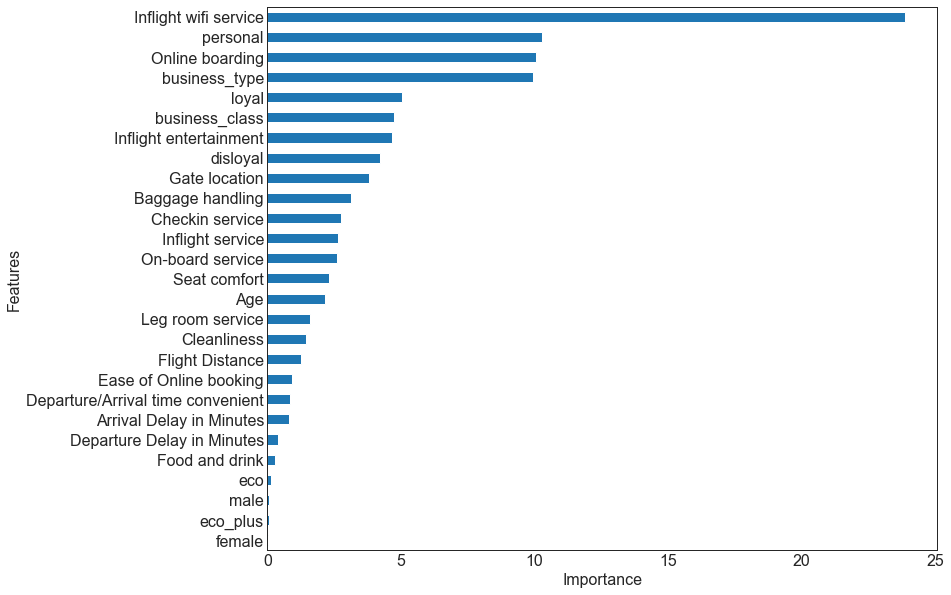

In [95]:
df = pd.DataFrame({'import': model.feature_importances_, 'feat': X.columns})
df = df.sort_values(['import', 'feat'], ascending=[True, False])
df.plot(kind='barh', x='feat', y='import', figsize=(12, 10), legend=None)
plt.ylabel('Features')
plt.xlabel('Importance')

Теперь попробуем xgboost с определенным набором параметров

In [96]:
import xgboost as xgb

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [97]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

param = {
   'max_depth': 8,
   'eta': 0.3, 
   'silent': 1, 
   'objective': 'multi:softprob',
   'num_class': 2}
num_round = 20

bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

best_preds = np.asarray([np.argmax(line) for line in preds])
print('Test Precision %.3f\n' %precision_score(y_test, best_preds, average='macro'))

Test Precision 0.962



In [98]:
bst.get_score(importance_type='cover')

{'Online boarding': 4386.298750319997,
 'Inflight wifi service': 2220.7477708102874,
 'Inflight entertainment': 1046.4731136096063,
 'business_class': 2083.6605425312514,
 'Ease of Online booking': 684.3682939191256,
 'business_type': 2308.85345425589,
 'loyal': 1181.513192731547,
 'Flight Distance': 264.9962954296132,
 'Checkin service': 1135.472716309832,
 'Baggage handling': 695.6097753941528,
 'Inflight service': 621.8839831620897,
 'Cleanliness': 936.4944757425462,
 'Gate location': 551.9206484357926,
 'Departure Delay in Minutes': 194.42019225330878,
 'Age': 378.96248405101784,
 'Leg room service': 676.5763017853247,
 'Arrival Delay in Minutes': 539.3315599790191,
 'On-board service': 961.1188463434423,
 'Departure/Arrival time convenient': 217.13789277354851,
 'Seat comfort': 762.4166966815734,
 'eco_plus': 778.213989,
 'Food and drink': 165.29658019226198,
 'male': 39.86095493333333,
 'eco': 286.43277120000005}

Text(0.5, 0, 'Importance')

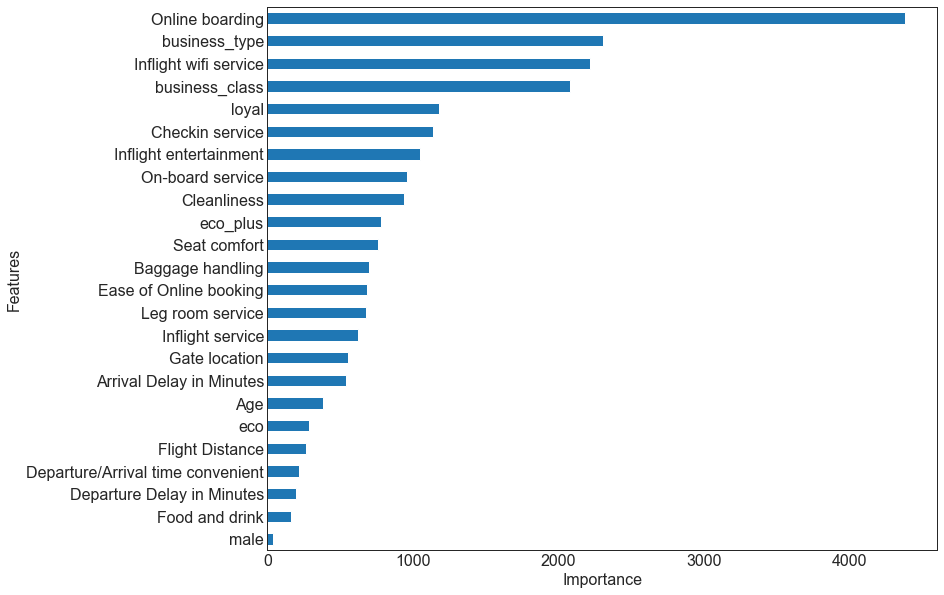

In [99]:
df = pd.DataFrame({'import': np.array(list(bst.get_score(importance_type='cover').values())), 'feat': np.array(list(bst.get_score().keys()))})
df = df.sort_values(['import', 'feat'], ascending=[True, False]).iloc[-30:]
df.plot(kind='barh', x='feat', y='import', figsize=(12, 10), legend=None)
plt.ylabel('Features')
plt.xlabel('Importance')

Получаем, что catboost лучше справился с задачей, хотя оба результата очень точные

В совокупности набор визуализирующих графиков и эти модели создают хороший инструмент для анализа удовлетворённости клиентов. Причём по Твиттеру это может быть ежедневная картина с почасовым изменением активности, по Skytrax это полная карта характеристик полёта в виде гистограмм по тысячам отзывов, а по анкетированию это наиболее точное предсказание удовлетворённости клиентов